# Проект "Линейные модели в машинном обучении"

Фермер из хозяйства «Вольный луг» хочет закупить коров и просит разработать модель машинного обучения, которая поможет выбрать животных с высоким удоем и вкусным молоком. Ассоциация «ЭкоФерма» предоставляет данные о коровах. Мы строим две модели: первая прогнозирует годовой удой, вторая — вероятность вкусного молока. Цель — отобрать только тех коров, которые дают не менее 6000 кг молока в год и соответствуют критериям вкусовых качеств.


## Оглавление<a name="0"></a> 

1. [Оглавление](#0)
2. [Загрузка данных](#1)
3. [Функции](#2)
4. [Предобработка данных](#3)
   * [4.1. Датасет ferma_main](#4)
   * [4.2. Датасет cow_buy](#5)
   * [4.3. Датасет ferma_dad](#6)
   * [4.4. Обработка неявных дубликатов](#7)
5. [Исследовательский анализ данных](#8)
   * [5.1. Количественные признаки](#9)
       * [5.1.1. Датасет ferma_main](#10)
       * [5.1.2. Датасет cow_buy](#11)
    * [5.2. Качественные признаки](#12)
       * [5.2.1. Датасет ferma_main](#13)
       * [5.2.2. Датасет cow_buy](#14)
    * [5.3. Корреляционный анализ данных](#15)
6. [Задача регрессии](#16)
    * [6.1. Первая модель](#17)
    * [6.2. Вторая модель](#18)
    * [6.3. Третья модель](#19)
    * [6.4. Прогнозирование коров на покупку](#20)
7. [Задача классификации](#21)
    * [7.1. Прогнозирование по вкусу молока](#000)
8. [Вывод](#22)

## Загрузка данных <a name="1"></a> 

Для начала работы импортируем необходимые библиотеки и загрузим данные

In [2]:
!pip install phik

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import math
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")

In [3]:
ferma_main = pd.read_csv('ferma_main.csv', sep = ';')
ferma_dad = pd.read_csv('ferma_dad.csv', sep = ';')
cow_buy = pd.read_csv('cow_buy.csv', sep = ';')

ferma2 = ferma_main
ds_list = [ferma_main, ferma_dad, cow_buy]

Ознакомимся с данными

In [4]:
for entry in ds_list:
    display(entry.sample(3))

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
26,27,6051,"14,8",1901,"0,93",РефлешнСоверинг,Холмистое,Айдиалл,"3,72","3,074",вкусно,более_2_лет
404,405,6638,"15,8",2334,"0,95",РефлешнСоверинг,Холмистое,Соверин,"3,72","3,078",вкусно,более_2_лет
451,452,6997,"15,4",2002,"0,94",РефлешнСоверинг,Холмистое,Айдиал,"3,71","3,072",не вкусно,более_2_лет


,id,Имя Папы
523,524,Соловчик
78,79,Барин
125,126,Барин


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,"3,73","3,079",более_2_лет


## Функции <a name="2"></a> 

In [5]:
# Нормализатор текста в ячейках
def normalize_text(df: pd.DataFrame) -> pd.DataFrame:
    df_norm = df.copy()
    # выберем текстовые колонки (object и category)
    text_cols = df_norm.select_dtypes(include=['object', 'category']).columns
    for col in text_cols:
        df_norm[col] = (
            df_norm[col]
            .astype(str)
            .str.lower()
            .str.replace(r'\s+', '', regex=True)
        )
        df = df_norm
    return df

In [6]:
# Просмотр уникальных значений в колонках
def print_unique_object_columns(df: pd.DataFrame) -> None:
    object_cols = df.select_dtypes(include='object').columns
    for col in object_cols:
        unique_vals = df[col].unique()
        print(f"Столбец '{col}':")
        for val in unique_vals:
            print(f"  – {val}")
        print()

In [7]:
# Построить боксплот и гистограмму + красиво оформить их
import matplotlib.pyplot as plt

def plot_hist_and_box(df, column, color='skyblue', bins=30, figsize=(10, 4)):
    data = df[column].dropna()
    if color is None:
        color = 'skyblue'
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Гистограмма
    axes[0].hist(data, bins=bins, color=color, edgecolor='black')
    axes[0].set_title(f'Гистограмма "{column}"')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Количество')
    
    # Боксплот
    axes[1].boxplot(data, vert=False)
    axes[1].set_title(f'Boxplot "{column}"')
    axes[1].set_xlabel(column)
    plt.tight_layout()
    plt.show()

In [8]:

def plot_categorical_bar(df, column): 
    counts = df[column].value_counts(dropna=False)
    categories = counts.index.tolist()
    values = counts.values
    cmap = plt.cm.get_cmap('tab20', len(categories))
    colors = [cmap(i) for i in range(len(categories))]

    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(categories, values, color=colors, edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            height + max(values)*0.01,          
            f"{int(height)}", 
            ha='center', va='bottom', 
            fontsize=9
        )

    ax.set_title(f"Распределение категорий: {column}")
    ax.set_ylabel("Количество")
    ax.set_xlabel('')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()

## Предобработка данных <a name="3"></a> 

### Датасет ferma_main<a name="4"></a> 

Проведу предобработку по шаблону:
- Проверка на дубликаты
- Проверка на пропуски
- Проверка на корректность типов данных
- Приведение данных к snake_case

In [9]:
ferma_main[ferma_main.duplicated() == True]

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
632,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
633,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет


In [10]:
ferma_main = ferma_main.drop_duplicates()

In [11]:
ferma_main.isnull().sum()

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

Дубликаты удалили, а пропусков нет

Типы данных:
- Удой требует тип float
- ЭКЕ (Энергетическая кормовая единица) требуется тип float
- СПО требуется тип float
- Жирность требуется тип float
- Белок требуется тип float

Претворим это в жихнь

In [12]:
num_cols = [
    'Удой, кг',
    'ЭКЕ (Энергетическая кормовая единица)',
    'Сырой протеин, г',
    'СПО (Сахаро-протеиновое соотношение)',
    'Жирность,%',
    'Белок,%'
]
for col in num_cols:
    ferma_main[col] = ferma_main[col].astype(str).str.replace(',', '.').astype(float)
print("\nТипы после конвертации:")
print(ferma_main[num_cols].dtypes)


Типы после конвертации:
Удой, кг                                 float64
ЭКЕ (Энергетическая кормовая единица)    float64
Сырой протеин, г                         float64
СПО (Сахаро-протеиновое соотношение)     float64
Жирность,%                               float64
Белок,%                                  float64
dtype: object


Теперь переименую столбцы:

In [13]:
column_mapping = {
    'id': 'id',
    'Удой, кг': 'milk_yield_kg',
    'ЭКЕ (Энергетическая кормовая единица)': 'energy_feed_unit',
    'Сырой протеин, г': 'crude_protein_g',
    'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'sire_breed',
    'Жирность,%': 'fat_percent',
    'Белок,%': 'protein_percent',
    'Вкус молока': 'milk_taste',
    'Возраст': 'age'
}
ferma_main = ferma_main.rename(columns=column_mapping)

In [14]:
ferma_main = normalize_text(ferma_main)
ferma_main.sample(5)
ferma_main2 = ferma_main

Предобработку данного датасета завершили. Перейдем к следующему.

### Датасет cow_buy<a name="5"></a> 

Проверим на дубликаты, да пропуски

In [15]:
cow_buy.duplicated().sum()

4

In [16]:
cow_buy = cow_buy.drop_duplicates()

In [17]:
cow_buy.isnull().sum()

Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64

Их нет. Ништяк.

Переименуем столбцы

In [18]:
column_mapping = {
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'sire_breed',
    'Имя_папы': 'sire_name',
    'Текущая_жирность,%': 'current_fat_percent',
    'Текущий_уровень_белок,%': 'current_protein_percent',
    'Возраст': 'age'
}

cow_buy = cow_buy.rename(columns=column_mapping)

In [19]:
cow_buy['current_fat_percent'] = cow_buy['current_fat_percent'].str.replace(',', '.').astype(float)
cow_buy['current_protein_percent'] = cow_buy['current_protein_percent'].str.replace(',', '.').astype(float)

In [20]:
cow_buy = normalize_text(cow_buy)

Оценим результаты предобработки датасета

In [21]:
display(cow_buy.sample(5))
display(cow_buy.info())

,breed,pasture_type,sire_breed,sire_name,current_fat_percent,current_protein_percent,age
12,висбикайдиал,холмистое,айдиал,геркулес,3.68,3.046,более_2_лет
7,висбикайдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет
17,рефлешнсоверинг,равнинное,соверин,геркулес,3.77,3.053,менее_2_лет


<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   breed                    16 non-null     object 
 1   pasture_type             16 non-null     object 
 2   sire_breed               16 non-null     object 
 3   sire_name                16 non-null     object 
 4   current_fat_percent      16 non-null     float64
 5   current_protein_percent  16 non-null     float64
 6   age                      16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


None

### Датасет ferma_dad<a name="6"></a> 

In [22]:
ferma_dad.isnull().sum()

id          0
Имя Папы    0
dtype: int64

In [23]:
ferma_dad.duplicated().sum()

0

Нет пропусков и дубликатов

In [24]:
column_mapping = {
    'id': 'id',
    'Имя Папы': 'sire_name'
}
ferma_dad = ferma_dad.rename(columns=column_mapping)

ferma_dad['id'] = ferma_dad['id'].astype(int)

ferma_dad = normalize_text(ferma_dad)

In [25]:
display(ferma_dad.sample(5))
display(ferma_dad.info())

,id,sire_name
85,86,буйный
608,609,соловчик
357,358,буйный
340,341,буйный
36,37,барин


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         629 non-null    int32 
 1   sire_name  629 non-null    object
dtypes: int32(1), object(1)
memory usage: 7.5+ KB


None

### Обработка неявных дубликатов<a name="7"></a> 

In [26]:
print_unique_object_columns(cow_buy)

Столбец 'breed':
  – висбикайдиал
  – рефлешнсоверинг

Столбец 'pasture_type':
  – холмистое
  – равнинное

Столбец 'sire_breed':
  – айдиал
  – соверин

Столбец 'sire_name':
  – геркулес
  – буйный
  – барин
  – соловчик

Столбец 'age':
  – более_2_лет
  – менее_2_лет



In [27]:
print_unique_object_columns(ferma_main)

Столбец 'breed':
  – висбикайдиал
  – рефлешнсоверинг

Столбец 'pasture_type':
  – равнинное
  – равнинные
  – холмистое

Столбец 'sire_breed':
  – айдиал
  – соверин
  – айдиалл

Столбец 'milk_taste':
  – вкусно
  – невкусно

Столбец 'age':
  – более_2_лет
  – менее_2_лет



In [28]:
print_unique_object_columns(ferma_dad)

Столбец 'sire_name':
  – буйный
  – соловчик
  – барин
  – геркулес



Найдены неявные дубликаты:
* "Равнинные" --> "Равнинное"
* "Айдалл" --> "Айдал"

Это надо удалить, иначе будущей модели будет тяжелее

In [29]:
ferma_main['pasture_type'].replace({'равнинные': 'равнинное'}, inplace=True)
ferma_main['sire_breed'].replace({'айдиалл': 'айдиал'}, inplace=True)

display(ferma_main['pasture_type'].unique())

array(['равнинное', 'холмистое'], dtype=object)

На этом предобработка датасетов завершена. 

In [30]:
ds_list = [ferma_main, ferma_dad, cow_buy]
for entry in ds_list:
    display(entry.sample(2))
    display(entry.info())

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_taste,age
479,480,5535.0,11.8,1683.0,0.84,висбикайдиал,равнинное,соверин,3.22,3.077,невкусно,менее_2_лет
513,514,6262.0,14.0,1708.0,0.93,рефлешнсоверинг,холмистое,айдиал,3.63,3.072,невкусно,более_2_лет


<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   629 non-null    int64  
 1   milk_yield_kg        629 non-null    float64
 2   energy_feed_unit     629 non-null    float64
 3   crude_protein_g      629 non-null    float64
 4   sugar_protein_ratio  629 non-null    float64
 5   breed                629 non-null    object 
 6   pasture_type         629 non-null    object 
 7   sire_breed           629 non-null    object 
 8   fat_percent          629 non-null    float64
 9   protein_percent      629 non-null    float64
 10  milk_taste           629 non-null    object 
 11  age                  629 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 63.9+ KB


None

,id,sire_name
552,553,буйный
325,326,барин


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         629 non-null    int32 
 1   sire_name  629 non-null    object
dtypes: int32(1), object(1)
memory usage: 7.5+ KB


None

,breed,pasture_type,sire_breed,sire_name,current_fat_percent,current_protein_percent,age
18,висбикайдиал,равнинное,соверин,буйный,3.34,3.069,более_2_лет
7,висбикайдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет


<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 0 to 18
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   breed                    16 non-null     object 
 1   pasture_type             16 non-null     object 
 2   sire_breed               16 non-null     object 
 3   sire_name                16 non-null     object 
 4   current_fat_percent      16 non-null     float64
 5   current_protein_percent  16 non-null     float64
 6   age                      16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


None

## Исследовательский анализ данных<a name="8"></a> 

В этом блоке мы:
* Проведем статистический анализ всех признаков
* Построим графики для них
* Оценим:
    * Есть ли выбросы
    * Нормально ли распределение
    * Есть ли особенности
    * Придумаем как улучшить данные

### Количественные признаки <a name="9"></a> 

#### Датасет ferma_main<a name="10"></a> 

In [31]:
color = 'skyblue'

Признак `milk_yield_kg`

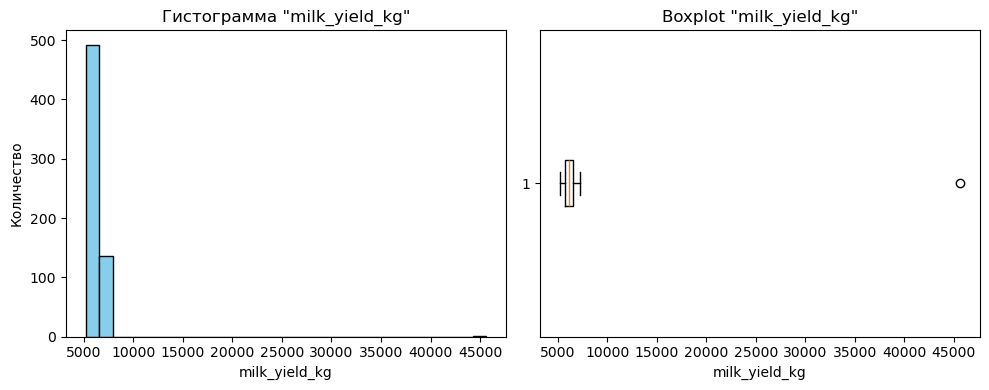

In [32]:
plot_hist_and_box(ferma_main, 'milk_yield_kg', color)

По признаку milk_yield_kg нашелся один выброс. От него можно просто безболезненно избавиться. Видно, что распределение признака отдалённо напоминает нормальное, но все же недо конца. Вероятно, это связано со спецификой признака (например, коров, которые в год дают <5200 л. молока нерентабельно ни содержать на ферме, ни продавать)

In [33]:
ferma_main = ferma_main[ferma_main['milk_yield_kg'] < 40000]

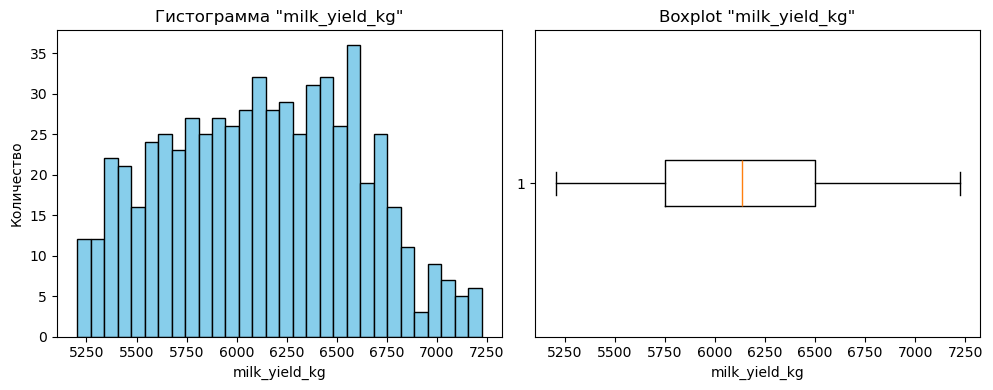

In [34]:
plot_hist_and_box(ferma_main, 'milk_yield_kg')

1. **Нормальность:** распределение в целом близко к нормальному, с лёгким скошением вправо (более длинный «хвост» к большим значениям).
2. **Выбросы:** явных выбросов нет – «усы» укладываются примерно от \~5200 до \~7250 кг без отдельных точек за пределами.
3. **Основной диапазон:** большинство значений сосредоточено между 5700 и 6700 кг; медиана примерно на уровне 6150–6250 кг.
4. **Примечание:** нижние значения (\~5200–5500 кг) могут соответствовать первотёлкам или коровам в ранней лактации, тогда как верхний диапазон (\~7000+ кг) характерен для высокопродуктивных особей.


Признак `energy_feed_unit`

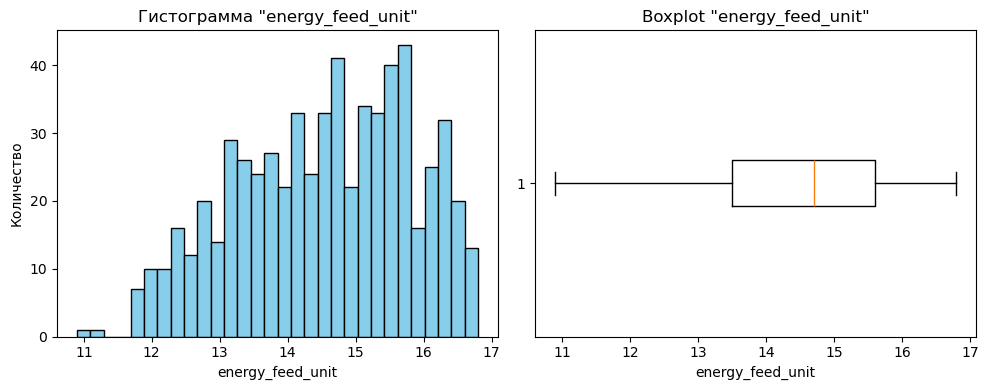

In [35]:
plot_hist_and_box(ferma_main, 'energy_feed_unit', color)

1. **Нормальность:** распределение примерно симметричное, близко к нормальному, с лёгким уклоном влево.
2. **Выбросы:** явных выбросов нет – значения от \~11 до \~17 укладываются в «усы» без крайних точек.
3. **Основной диапазон:** большинство значений лежит между 13 и 16 единицами; медиана около 14,7–15,0.
4. **Примечание:** нижние значения (\~11–12) могут относиться к кормлению молодняка или особым режимам, тогда как 14–16 — стандартный уровень для основной группы коров.


Признак `crude_protein_g`

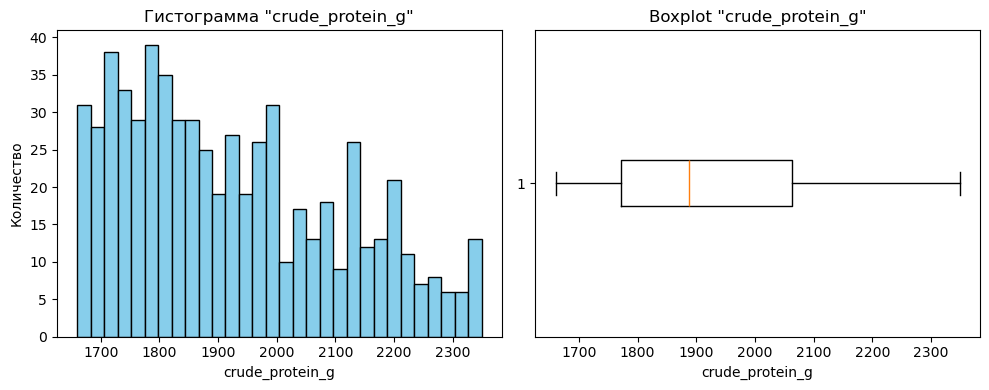

In [36]:
plot_hist_and_box(ferma_main, 'crude_protein_g', color)

1. **Нормальность:** распределение близко к симметричному, но есть лёгкий сдвиг вправо и намёк на две группы (около 1750 и 2200 г).
2. **Выбросы:** явных выбросов нет – «усы» тянутся примерно от 1650 до 2350 г без отдельных точек.
3. **Основной диапазон:** большинство значений лежит между \~1800 и \~2050 г; медиана около 1900 г.
4. **Примечание:** низкие значения (\~1650–1750 г) могут соответствовать базовым рационам, высокие (\~2200+ г) – усиленному протеиновому питанию для высокопродуктивных коров.

Признак `sugar_protein_ratio`

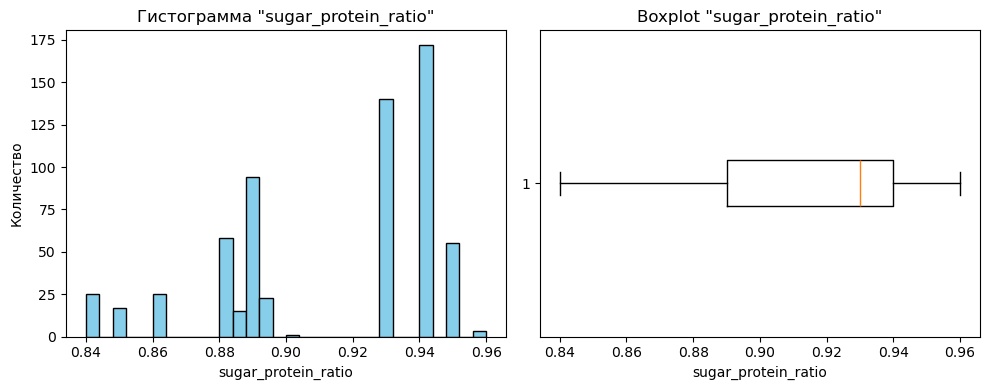

In [37]:
plot_hist_and_box(ferma_main, 'sugar_protein_ratio', color)

1. **Нормальность:** форма не идеально нормальная, есть «скопления» значений (примерно вокруг 0.89 и 0.93), небольшой сдвиг вправо.
2. **Выбросы:** явных выбросов нет — размах от \~0.84 до \~0.96 укладывается в усы без отдельных точек.
3. **Основной диапазон:** большинство значений сосредоточено между \~0.89 и \~0.94; медиана около 0.92-0.93.
4. **Примечание:** дискретные «пики» могут отражать разные режимы кормления или стадии лактации: низкие соотношения (\~0.84–0.87) — для одной группы коров, высокие (\~0.93–0.95) — для другой.

Признак `fat_percent`

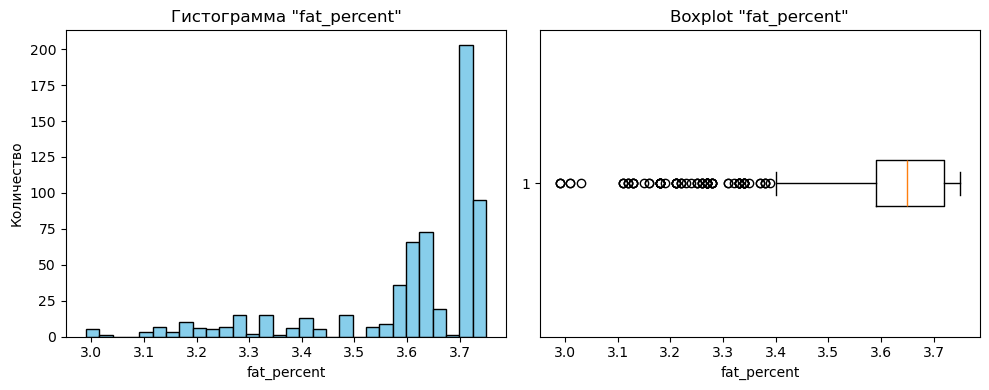

In [38]:
plot_hist_and_box(ferma_main, 'fat_percent', color)

1. **Нормальность:** распределение сильно не нормальное – выраженный сдвиг влево (большой «пик» на высоких значениях и длинный «хвост» к низким).
2. **Выбросы:** множество точек-выбросов слева (жирности \~3.0–3.4 %), которые лежат ниже нижнего «уса» (нижний квартиль примерно около 3.55 %) Однако их слишком много (approx. 13%) и избавиться от них "безболезненно" не выйдет. Посмотрим что мы с ними можем сделать.
3. **Основной диапазон:** центральные 50 % значений сосредоточены между ≈3.55 % и ≈3.72 %; медиана около 3.65 %.
4. **Примечание:** высокая концентрация в районе 3.65–3.75 % говорит о стандартном уровне жирности большинства коров, тогда как низкие значения (\~3.0–3.4 %) могут соответствовать либо первым отёлам, либо сезонным/рационным изменениям.


Признак `protein_percent`

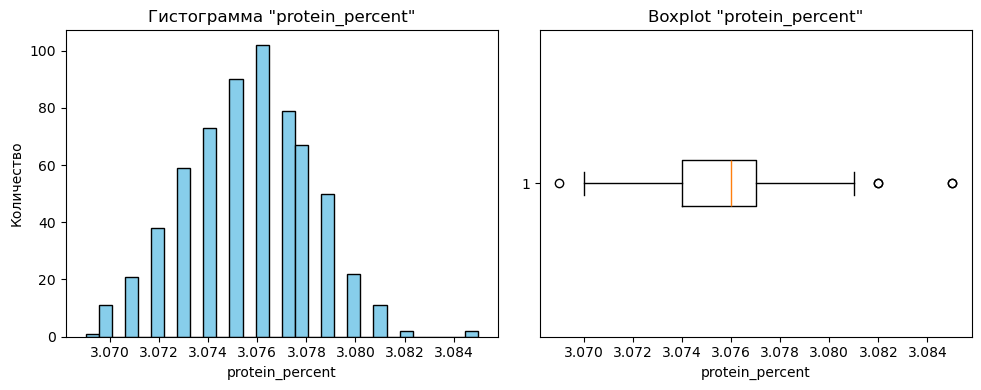

In [39]:
plot_hist_and_box(ferma_main, 'protein_percent', color)

1. **Нормальность:** распределение близко к нормальному, симметричное вокруг ≈3.076 %;
2. **Выбросы:** есть единичные точки слева (\~3.070) и справа (\~3.082–3.085), лежащие за «усами», от них можно и избавиться;
3. **Основной диапазон:** центральные 50 % значений примерно от 3.074 % до 3.078 %; медиана ≈3.076 %;
4. **Примечание:** крайние низкие или высокие проценты белка могут отражать особенности питания, стадию лактации или погрешности измерения.

In [40]:
Q1 = ferma_main['protein_percent'].quantile(0.25)
Q3 = ferma_main['protein_percent'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

ferma_main = ferma_main[
    (ferma_main['protein_percent'] >= lower_bound) &
    (ferma_main['protein_percent'] <= upper_bound)
].copy()

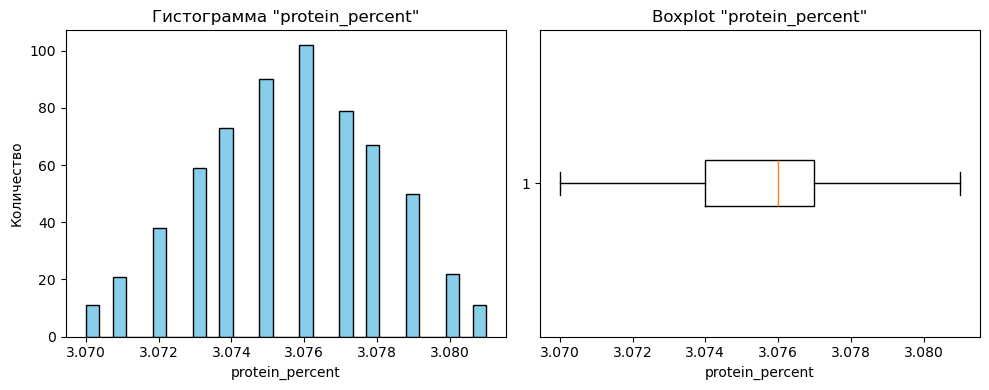

In [41]:
plot_hist_and_box(ferma_main, 'protein_percent', color)

#### Датасет cow_buy<a name="11"></a> 

In [42]:
color = 'lightgreen'

Признак `current_fat_percent`

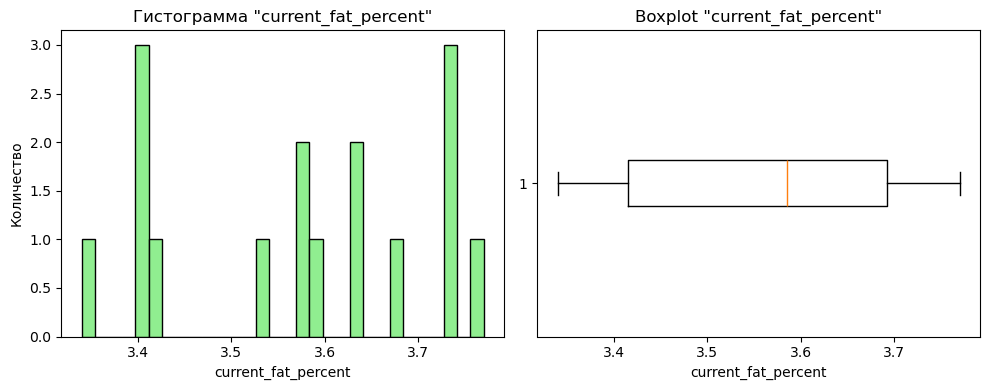

In [43]:
plot_hist_and_box(cow_buy, 'current_fat_percent', color)

Признак `current_protein_percent`

1. **Нормальность:** распределение выглядит относительно симметричным, хоть и дискретным (данных немного и они сгруппированы вокруг нескольких значений). Явного уклона нет.
2. **Выбросы:** на боксплоте нет отдельных точек за пределами «усов» — все значения (примерно от 3.32 до 3.75 %) укладываются в допустимый диапазон без ярко выраженных выбросов.
3. **Основной диапазон:** центральные 50 % значений лежат примерно между 3.52 % и 3.68 % (медиана около 3.60 %).
4. **Примечание:** низкие показания (\~3.32–3.40 %) вероятно соответствуют коровам в начале лактации или при изменении рациона, а верхние (\~3.70–3.75 %) — зрелым животным со стабильно высоким содержанием жира.


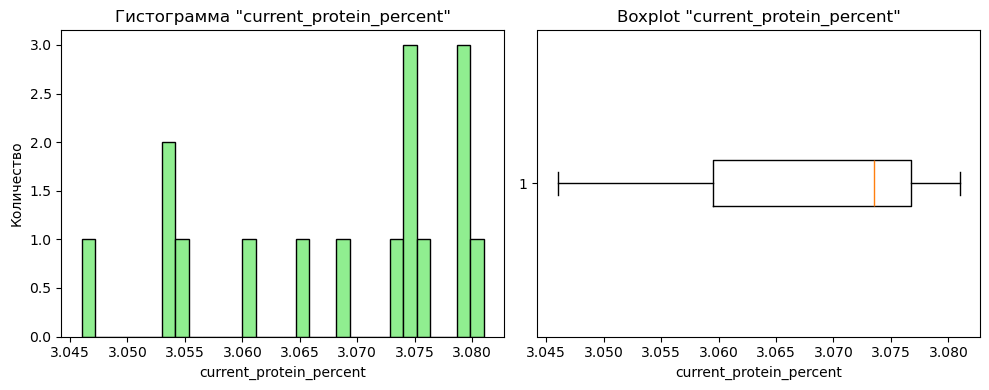

In [44]:
plot_hist_and_box(cow_buy, 'current_protein_percent', color)

1. **Нормальность:** данных немного и они дискретны, но в целом распределение скучено вокруг \~3.075 % с небольшим «хвостом» вниз — близко к симметричному, но не идеально нормальное.
2. **Выбросы:** одна точка около 3.045 % лежит за нижним «усом» на боксплоте и считается выбросом.
3. **Основной диапазон:** остальные значения сосредоточены между ≈3.055 % и ≈3.080 %; медиана примерно на уровне 3.075 %.
4. **Примечание:** низкая точка (\~3.045 %) может относиться к корове с пониженным содержанием белка (возможно, первотёлка или особые условия кормления), тогда как большинство животных демонстрируют 3.07–3.08 % билируина.


In [45]:
cow_buy = cow_buy[cow_buy['current_protein_percent'] > 3.054]

### Качественные признаки<a name="12"></a> 

#### Датасет ferma_main<a name="13"></a> 

Признак `breed`

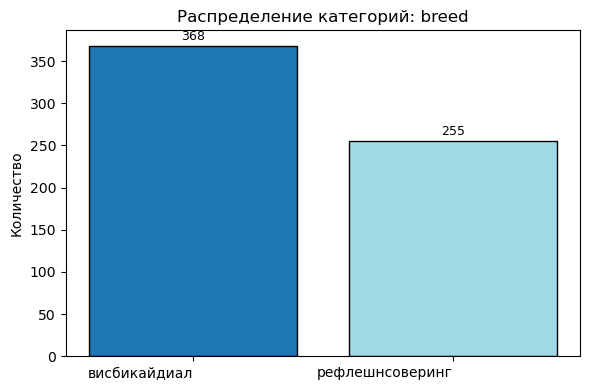

In [46]:
plot_categorical_bar(ferma_main, 'breed')

Видно два типа «висбид айдиал» (368) и «рефлешн соверинг» (255) — первая порода заметно преобладает.

Признак `pasture_type`

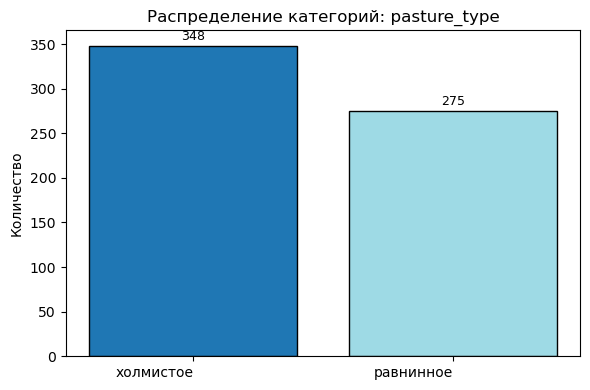

In [47]:
plot_categorical_bar(ferma_main, 'pasture_type')

Категории «холмистое» (348) и «равнинное» (275), при этом холмистое чуть более распространено.

Признак `sire_breed`

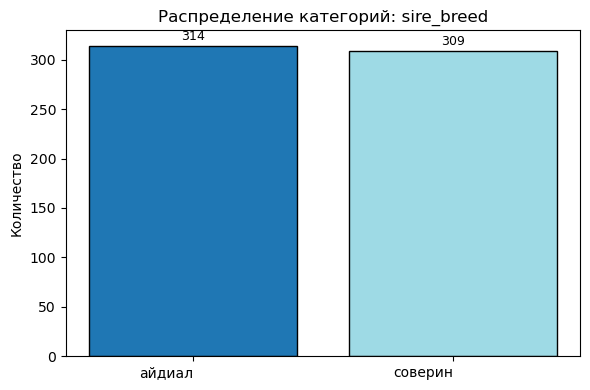

In [48]:
plot_categorical_bar(ferma_main, 'sire_breed')

«айдиал» (314) и «соверин» (309) почти равномерно представлены.

Признак `milk_taste`

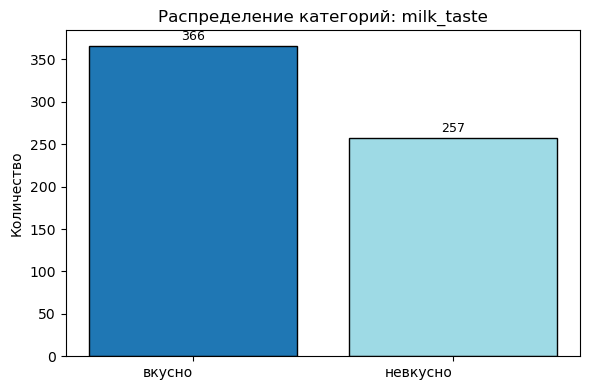

In [49]:
plot_categorical_bar(ferma_main, 'milk_taste')

две категории «вкусно» (366) и «невкусно» (257), вкусовое предпочитают чаще, но разрыв не слишком большой.

Признак `age`

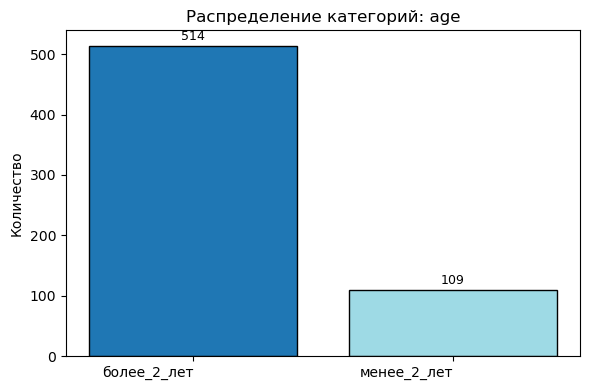

In [50]:
plot_categorical_bar(ferma_main, 'age')

«более_2_лет» (514) доминирует над «менее_2_лет» (109) — большинство коров старше двух лет, молодняка существенно меньше.

#### Датасет cow_buy<a name="14"></a> 

Признак `breed`

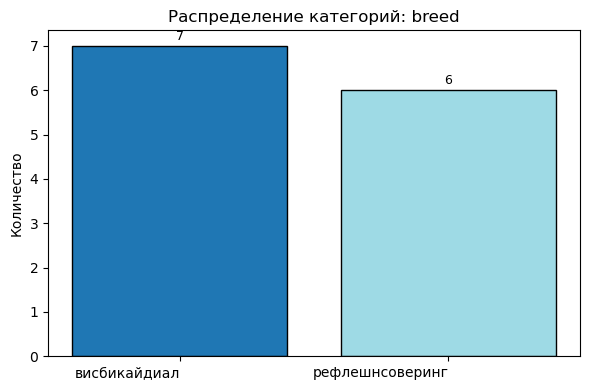

In [51]:
plot_categorical_bar(cow_buy, 'breed')

Признак `pasture_type`

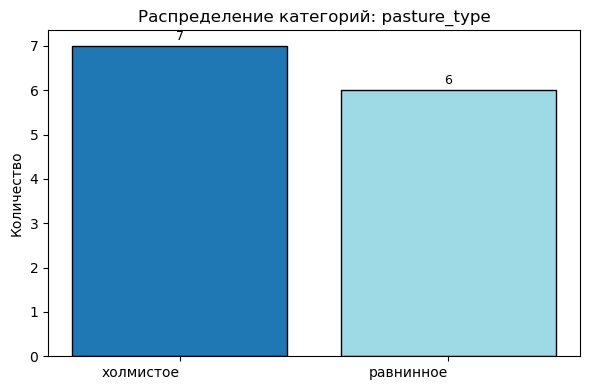

In [52]:
plot_categorical_bar(cow_buy, 'pasture_type')

Признак `sire_breed`

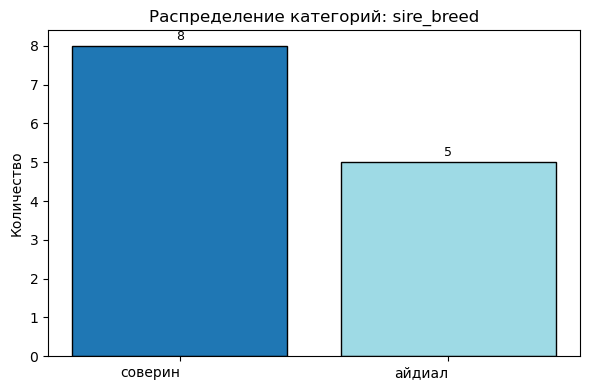

In [53]:
plot_categorical_bar(cow_buy, 'sire_breed')

Признак `sire_name`

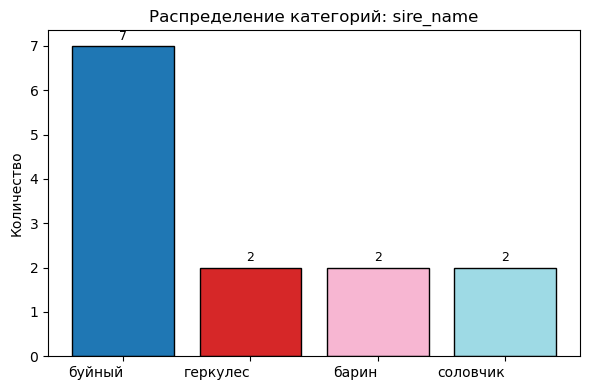

In [54]:
plot_categorical_bar(cow_buy, 'sire_name')

Признак `age`

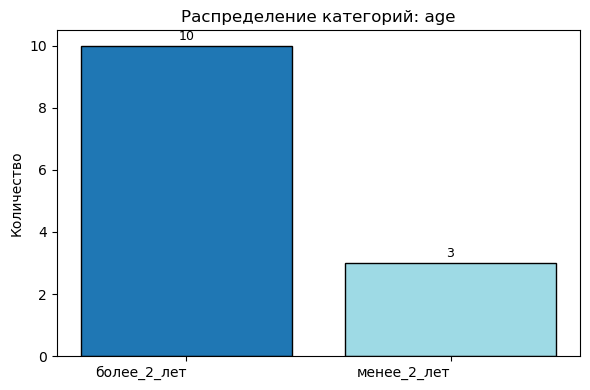

In [55]:
plot_categorical_bar(cow_buy, 'age')

**Как улучшить данные:**

Помимо того, что мы удалили выбросы, объеденили некоторые признаки в один, т.к. являлись неявными дубликатами, стоит:
* Закодировать категориальные признаки
* Проверить данные на мультиколинеарность и избавиться при необходимости от некоторых признаков
* Нормализовать данные для обучения модели
* Что-то придумать с дисбалансом в некоторых областях (возраст, например)

Это конец исследовательского анализа данных

## Корреляционный анализ данных для ferma_main<a name="15"></a> 

Займемся корреляционным анализом данных. В этих целях далее мы:
* Рассчитаем коэффициенты корреляции между всеми признаками
* Построим диаграммы рассеяния для наглядности
* Сделаем выводы о взаимосвязи признаков

Матрица корреляций в виде heatmap с выведенными коэффициентами:

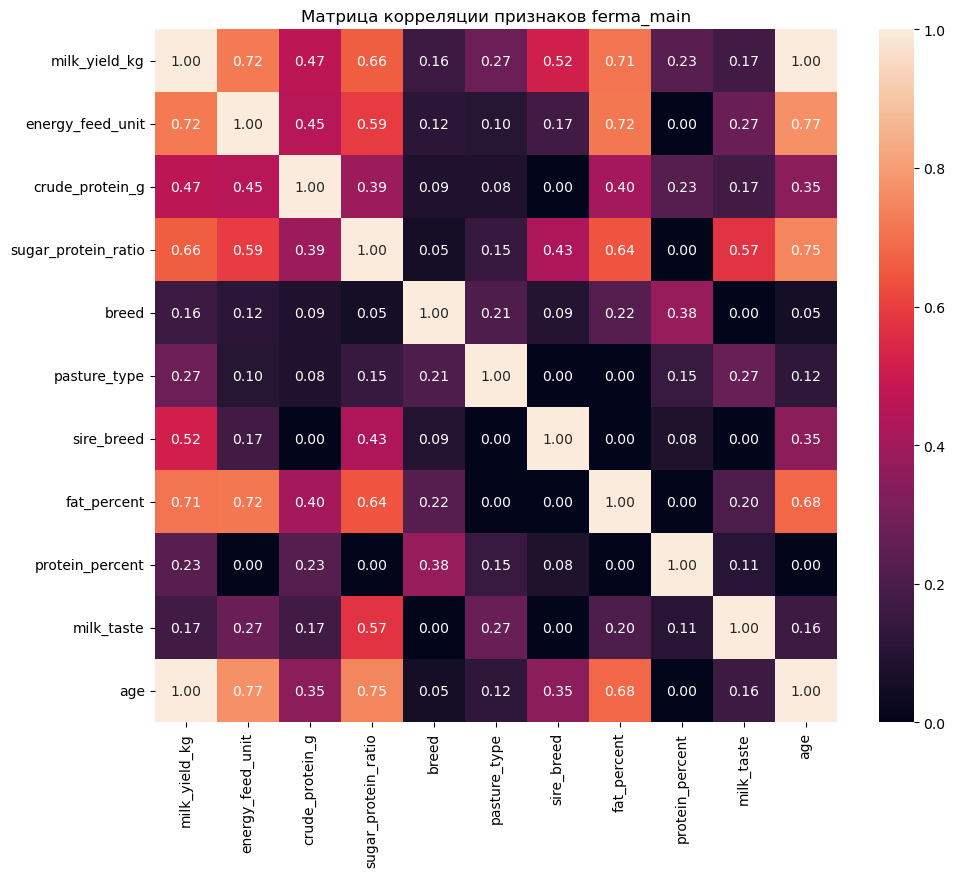

In [56]:
plt.figure(figsize = (11, 9))
df = ferma_main
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed')]
df = df.drop(columns=['id'])
corr_phik = df.phik_matrix(interval_cols=df.select_dtypes(include='number').columns)
sns.heatmap(corr_phik, annot=True, fmt='.2f') 
plt.title('Матрица корреляции признаков ferma_main')
plt.show();

**Подвывод:**

Из интересного было обнаружено, что

1) Очень сильно на вкус молока влияет содержание в нем сахара
2) С надоем очень сильно коррелируют процент жирности, порода отца, отношение сахара к протеину в корме и энергетическая ценность корма, но об этом поговорим позже
3) Процент жирности сильно коррелирует со многими параметрами коровы и её питания

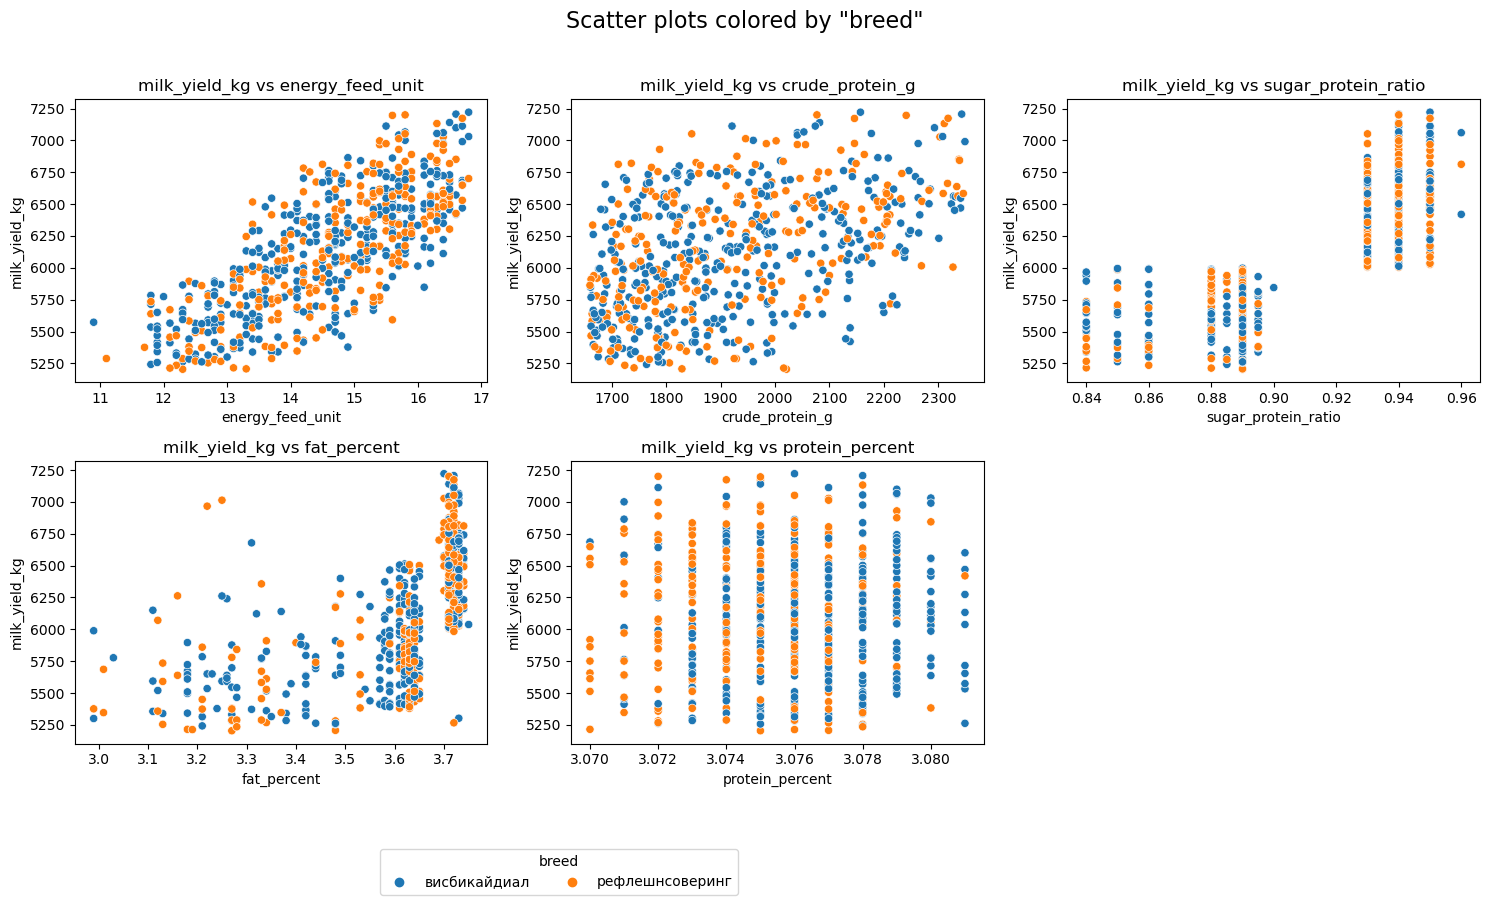

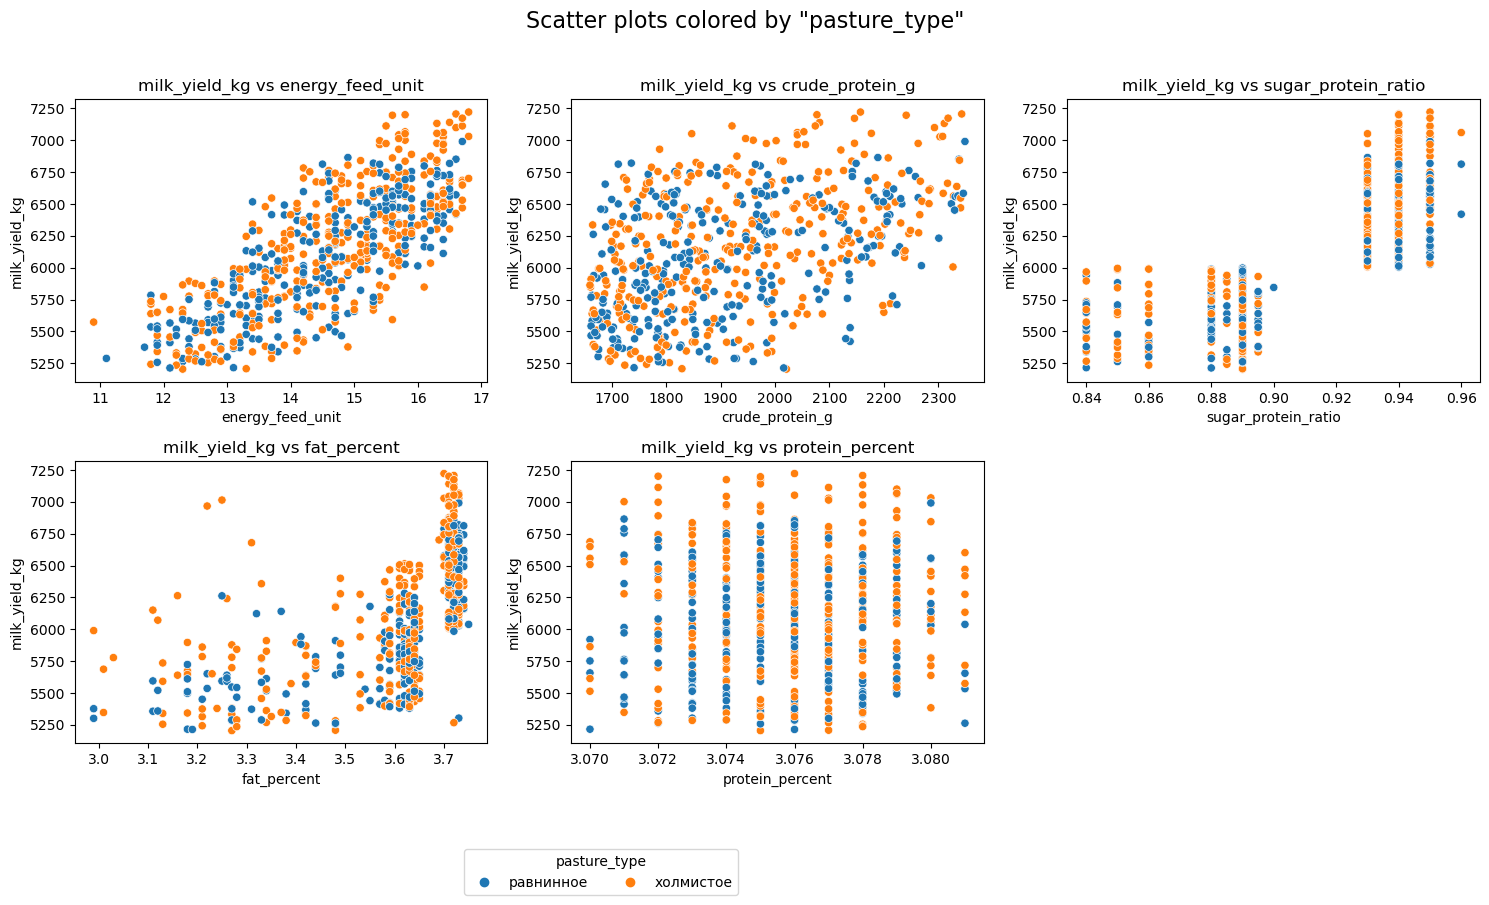

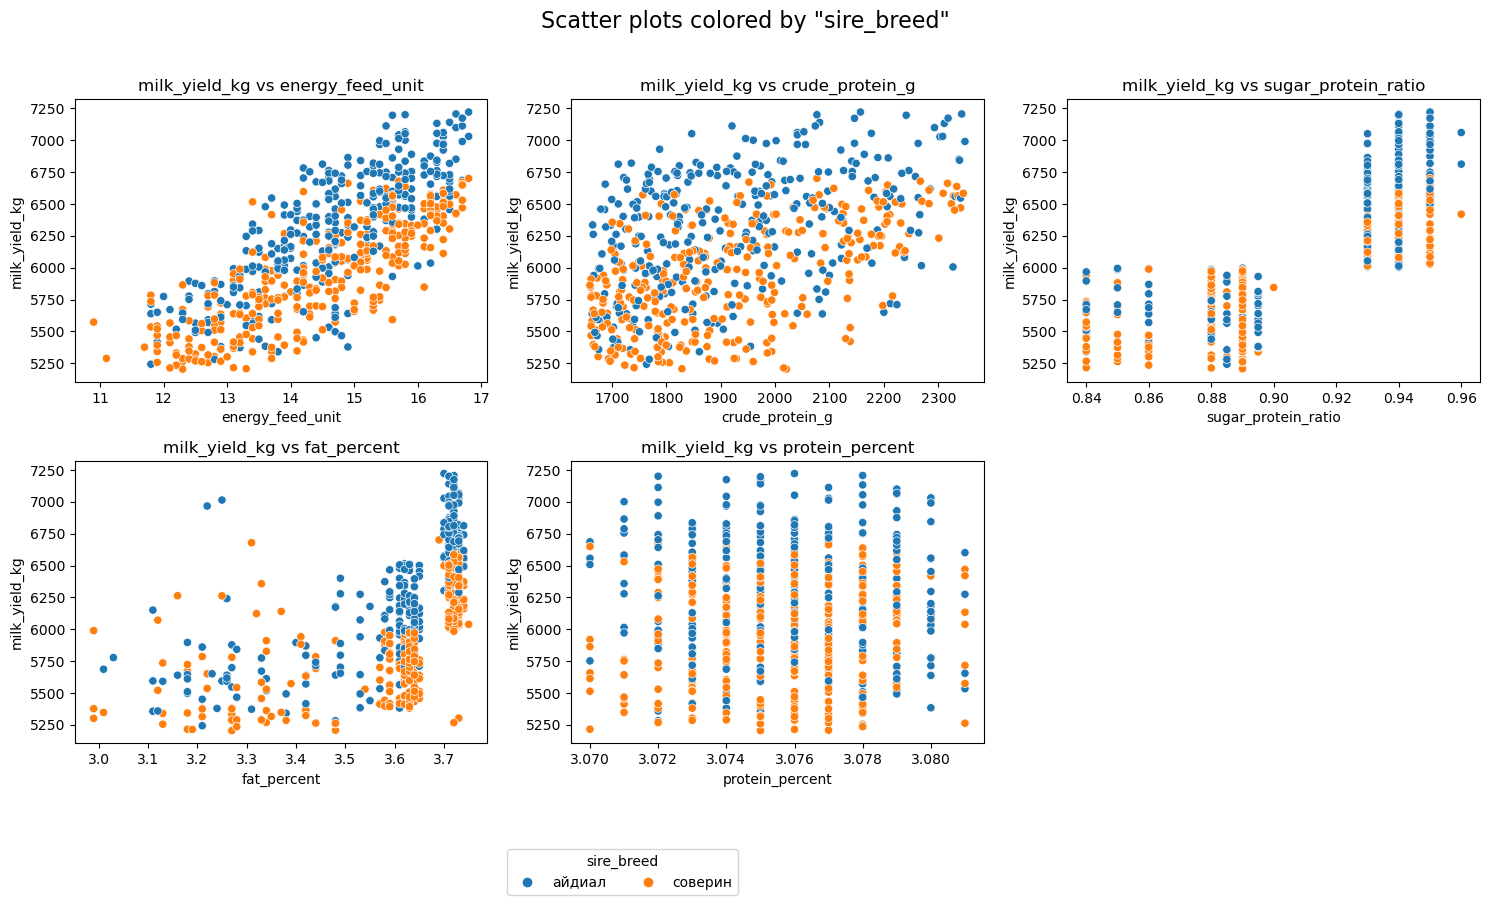

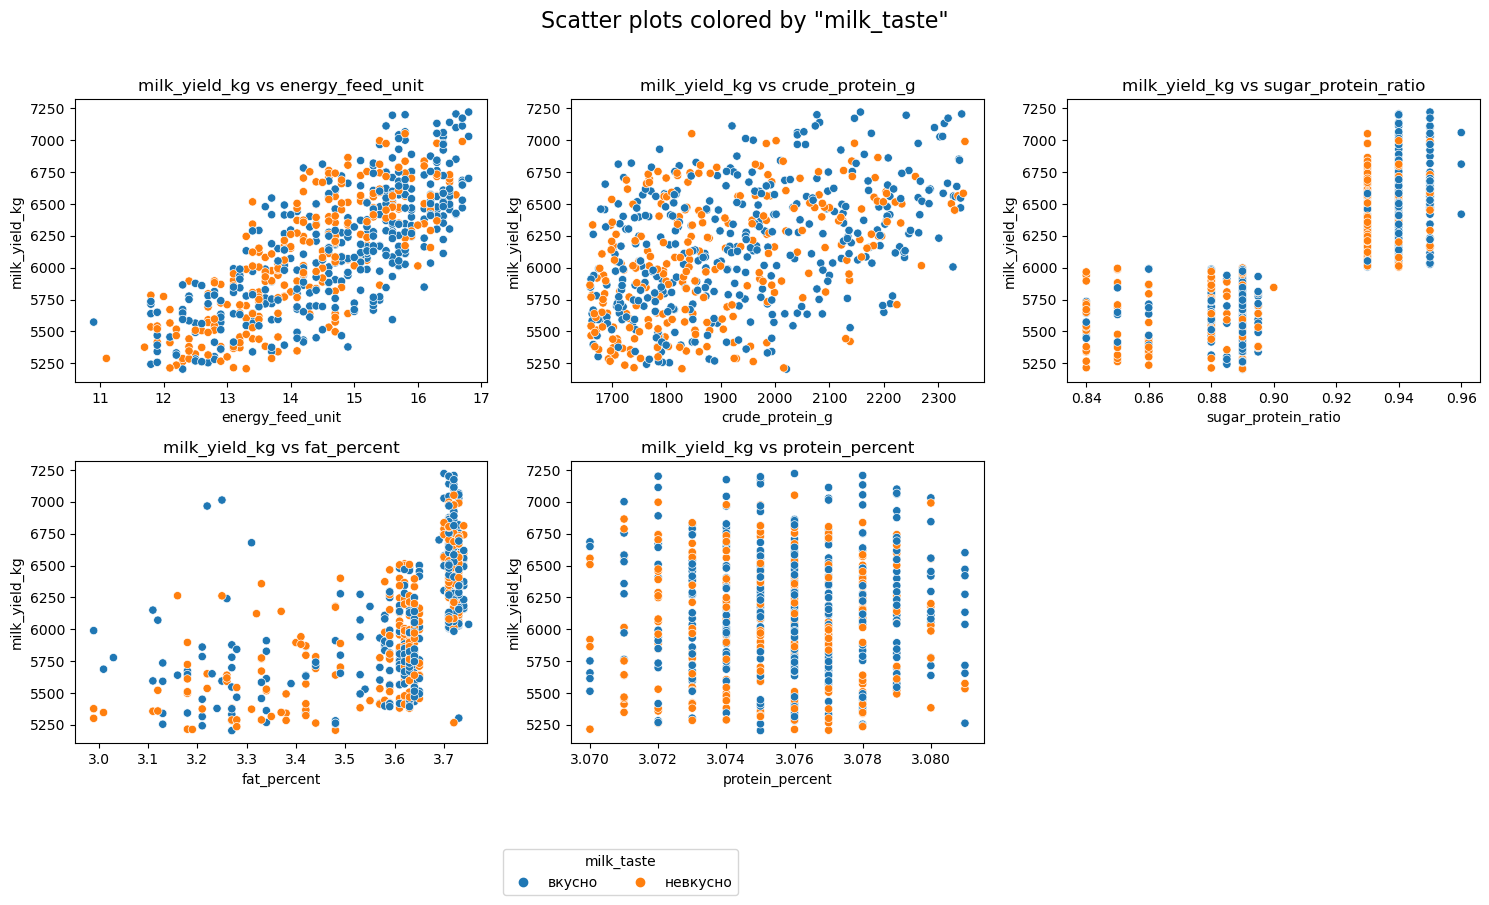

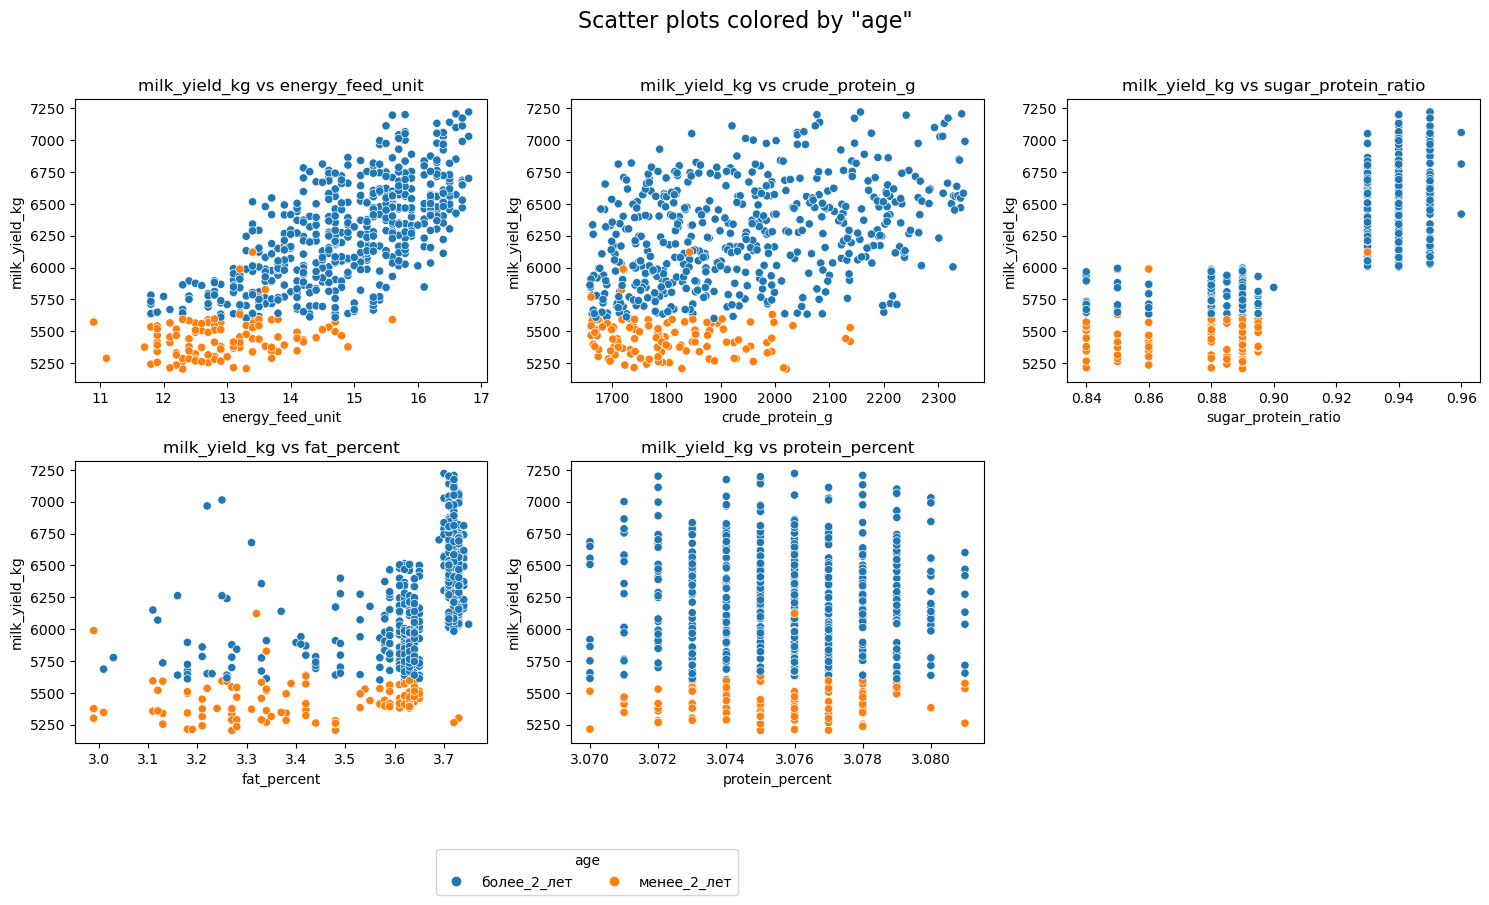

In [57]:
quantitative_cols = [
    'energy_feed_unit',
    'crude_protein_g',
    'sugar_protein_ratio',
    'fat_percent',
    'protein_percent'
]

categorical_cols = ['breed', 'pasture_type', 'sire_breed', 'milk_taste', 'age']

ncols = 3
nrows = math.ceil(len(quantitative_cols) / ncols)

for cat in categorical_cols:
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8), squeeze=False)
    axes_flat = axes.flatten()
    
    for idx, q in enumerate(quantitative_cols):
        ax = axes_flat[idx]
        sns.scatterplot(
            data=df,
            x=q,
            y='milk_yield_kg',
            hue=cat,
            legend=False,
            ax=ax
        )
        ax.set_title(f'milk_yield_kg vs {q}')
        ax.set_xlabel(q)
        ax.set_ylabel('milk_yield_kg')
    
    for ax in axes_flat[len(quantitative_cols):]:
        ax.axis('off')
    
    uniques = df[cat].unique()
    palette = sns.color_palette(n_colors=len(uniques))
    legend_handles = [
        Line2D([0], [0],
               marker='o',
               color=palette[i],
               linestyle='',
               label=uniques[i])
        for i in range(len(uniques))
    ]
    
    fig.suptitle(f'Диаграмма рассеяния по признаку "{cat}"', fontsize=16, y=1.02)
    
    fig.legend(
        handles=legend_handles,
        title=cat,
        bbox_to_anchor=(0.5, -0.02),
        ncol=len(uniques)
    )
    
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.show()


**Выводы:**


__Breed__:

1) **Зависимость надоя от питательности корма:** видна довольно четкая прямая корреляция между тем насколько питательный корм у коровы и тем сколько надоя в год она даёт. Энергетические единицы (energy_feed_unit) – самый сильный драйвер роста milk_yield_kg. Обе породы чётко показывают: чем кормить «больше энергии», тем выше общий объём молока. У «рефлешн соверинг» эта зависимость, кажется, чуть более выражена на верхних уровнях кормления, но общее направление одинаковое. И слава Богу.
2) **Зависимость надоя от содержания сырого протеина в корме:** прослеживается слабая прямая корреляция между этими двумя параметрами. Сырое содержание протеина в рационе оказывает определённое влияние, но гораздо слабее, чем «чистая» энергия. Разброс точек говорит о том, что много других факторов («еда», «порода», «пасбище») вносят шум. При увеличении протеина выше ~2000 г молоко растёт, но именно «протеин + сопутствующая энергия» работают в связке, поэтому одному протеину доверять не стоит.
3) **Зависимость надоя от сахаро-протеинового соотношения в корме:** на графике мы можем заметить несколько "палочек" на константных знаечниях соотношения. Как видно, что после определенного порога в районе 0.91 значение надоя резко растет. При этом высокое соотношение сахара к протеину особо положительно сказывается на надое рефлешн соверингов.
4) **Зависимость надоя от содержания жира:** Диапазон значений молока растёт вместе с ростом жирности, но здесь опять видно, что точки разного цвета сильно пересекаются. У «висбикайдиал» (синие) чуть больше разброс на низкой жирности, тогда как у оранжевых («рефлешнсоверинг») часто наблюдаются более высокие урожаи близ 3.7 % жирности. Но чёткой границы (скажем, «жирность > 3.65 % = всегда больше молока вне зависимости от породы») нет — всё перемешано.
5) **Зависимость надоя от процента протеина:** Доля белка в молоке protein_percent в данном наборе практически никак не связана с объёмом производства (milk_yield_kg). Она настолько константна (от 3.070 до 3.080 %), что не даёт никакой дополнительной информации о том, «сколько литров» (килограммов) молока будет произведено.

**Кратко о типах связей:**
1) Практически линейная (жёсткое восхождение/убывание) – energy_feed_unit → milk_yield_kg.
2) Слабая линейная – crude_protein_g → milk_yield_kg (есть тренд, но сильный шум).
3) Почти отсутствует или очень слабо выражена – sugar_protein_ratio, fat_percent и особенно protein_percent.

__pasture_type__:

Можно заметить, что на равнинном пастбище точки более сгруппированы вокруг средней линии, с более узким разбросом надоя и почти без экстремальных значений, тогда как на холмистом пастбище разброс шире и присутствуют чуть более высокие пики надоя при тех же значениях питательности; при этом общий характер связи (например, между energy\_feed\_unit и milk\_yield\_kg) для обоих типов пастбищ остается практически одинаковым.

__sire_breed__

У потомков “айдял” точки чуть выше на оси надоя при тех же значениях питательности и более сконцентрированы вокруг среднего, а у “соверин” разброс чуть шире и чуть больше точек в нижнем хвосте; при этом общая зависимость между количественными показателями и надоем одинакова для обоих родословий.
:
__milk_taste_

У «вкусного» молока точки чуть чаще лежат в верхней части облака (то есть при равных показателях питательности получаются чуть более высокие надои) и сгруппированы плотнее, а у «невкусного» молока разброс чуть шире и больше точек с низкими надоями; при этом общий характер связи питательности и надоя практически не отличается.
_:
__age_
У более взрослых коров (синие точки) надои в среднем выше и плотнее «садятся» на тренд, а у молодых (оранжевые) – ниже и чуть рассеянее, но в обоих группах связь питательности кормов с надоем сохраняется примерно одинаковой.
_:

**Касаемо нелинейности и новых переменных:**

Явных негладких или сильно «изогнутых» кривых (U-, S-, лог- или экспонент-связей) не наблюдается. Всё вписывается в приближённо линейную модель («прямая плюс шум»), разве что с лёгким «затуханием» в максимуме energy_feed_unit, но оно настолько слабо, что не требует обязательного полинома. Вводить новые признаки не требуется, або линейная регрессия (или любая линейная модель с регуляризацией) вполне сможет отработать эти связи: energy Feed + протеин + остальные признаки «как есть».

**Мультиколлинеарность:**

Скорее всего, да, присутствует умеренная: особенно между `energy_feed_unit` и `crude_protein_g` (потому что более «энергетичные» корма обычно богаты протеином).

## Задача регрессии<a name="16"></a> 

В целях обучения модели регрессии было выбрано:

* Целевая переменная - `milk_yield_kg`
* Объясняющие переменные:
    * **Численные признаки**
         * `energy_feed_unit` - энергетическая ценность корма. Не будем использовать `crude_protein_g` из-за риска мультиколлинеарности
         * `fat_percent` - высокий уровень корреляции, существует определенная зависимость, судя по scatter_plot
         * `sugar_protein_ratio` - высокий уровень корреляции, возможно есть связь, согласно диаграме рассеяния
    * **Категориальные признаки**
        * `sire_breed` - порода отца. Очень высокая корреляция
        * `age` - логически имеет смысл. Старые коровы не должны давать много молока
        * `pasture_type` - корреляция чуть выше остальных признаков. Пусть будет

### Первая модель<a name="17"></a> 

In [58]:
ferma_main

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_taste,age
0,1,5863.0,14.2,1743.0,0.890,висбикайдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529.0,12.8,2138.0,0.890,висбикайдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810.0,14.0,1854.0,0.885,рефлешнсоверинг,холмистое,соверин,3.59,3.074,невкусно,более_2_лет
3,4,5895.0,12.4,2012.0,0.885,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,невкусно,более_2_лет
4,5,5302.0,12.8,1675.0,0.885,висбикайдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812.0,15.4,1964.0,0.940,рефлешнсоверинг,равнинное,айдиал,3.74,3.075,невкусно,более_2_лет
625,626,5513.0,12.9,1700.0,0.880,рефлешнсоверинг,равнинное,соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970.0,14.4,1837.0,0.880,рефлешнсоверинг,холмистое,соверин,3.64,3.075,невкусно,более_2_лет
627,628,5746.0,13.8,1994.0,0.890,рефлешнсоверинг,равнинное,соверин,3.64,3.077,вкусно,более_2_лет


In [59]:
ferma_main_orig = ferma_main

Определю целевую переменную, объясняющие признаки, а также разнесу по категориям столбцы:

In [60]:
y = ferma_main['milk_yield_kg']
X = ferma_main[['energy_feed_unit',
                'fat_percent',
                'sugar_protein_ratio', 
                'sire_breed', 
                'age', 
                'pasture_type']]

numeric_features = ['energy_feed_unit',
                    'sugar_protein_ratio',
                   'fat_percent']

categorical_features = ['pasture_type',
                        'sire_breed',
                        'age']

Разделим на выборки

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [62]:
# кодирование категориальных
encoder = OneHotEncoder(drop='first')
encoder.fit(X_train[categorical_features])

X_train_cat_arr = encoder.transform(X_train[categorical_features]).toarray()
X_test_cat_arr = encoder.transform(X_test[categorical_features]).toarray()

encoded_cols = encoder.get_feature_names_out(categorical_features)
X_train_cat = pd.DataFrame(X_train_cat_arr, columns=encoded_cols, index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat_arr, columns=encoded_cols, index=X_test.index)

# масштабирование числовых
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train_num_arr = scaler.transform(X_train[numeric_features])
X_test_num_arr = scaler.transform(X_test[numeric_features])

X_train_num = pd.DataFrame(X_train_num_arr, columns=numeric_features, index=X_train.index)
X_test_num = pd.DataFrame(X_test_num_arr, columns=numeric_features, index=X_test.index)


Соберу в единый датафрейм для просмотра

In [63]:
X_train = pd.concat([X_train_cat, X_train_num], axis=1)
X_test = pd.concat([X_test_cat, X_test_num], axis=1)

display(X_train.head(2), X_test.head(2))

,pasture_type_холмистое,sire_breed_соверин,age_менее_2_лет,energy_feed_unit,sugar_protein_ratio,fat_percent
211,0.0,0.0,1.0,-2.108843,-1.745369,-1.185011
315,1.0,1.0,0.0,0.465951,0.477227,0.730612


,pasture_type_холмистое,sire_breed_соверин,age_менее_2_лет,energy_feed_unit,sugar_protein_ratio,fat_percent
252,1.0,1.0,0.0,-0.704410,-0.792828,0.112669
564,0.0,1.0,1.0,-2.108843,-2.380396,-2.050132


Непосредственно обучу модель линейной регрессии далее:

In [64]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

# рассчитайте значения R2 для линейной регрессии
r2 = r2_score(y_test, predictions)  
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
# выведите полученное значение R2
print("R2 LinearRegression =", r2)

R2 LinearRegression = 0.7784963153266605


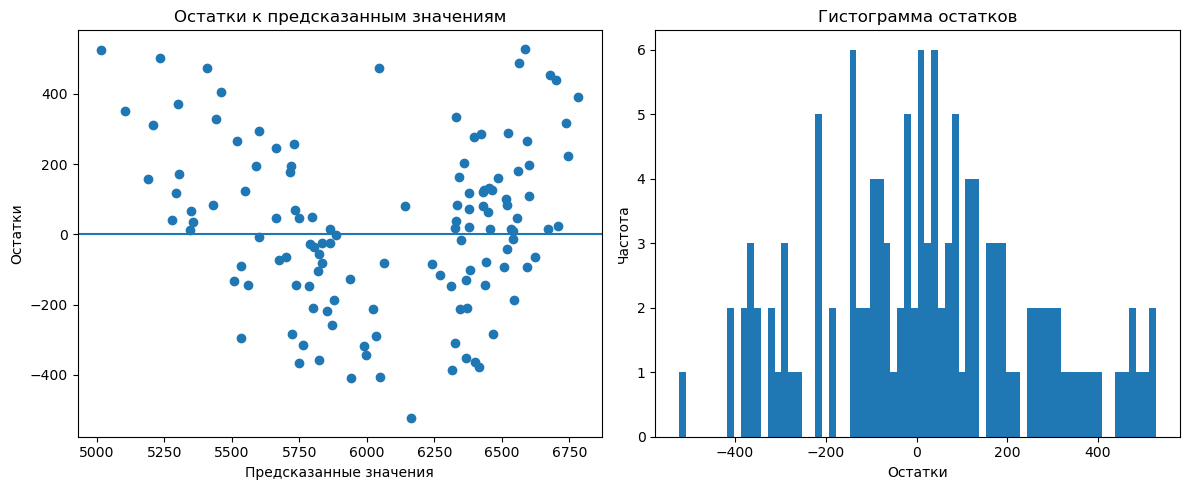

In [65]:
residuals = y_test - predictions

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(predictions, residuals)
axes[0].axhline(0)
axes[0].set_xlabel('Предсказанные значения')
axes[0].set_ylabel('Остатки')
axes[0].set_title('Остатки к предсказанным значениям')

axes[1].hist(residuals, bins=70)
axes[1].set_xlabel('Остатки')
axes[1].set_ylabel('Частота')
axes[1].set_title('Гистограмма остатков')

plt.tight_layout()
plt.show()


1. Значение R² модели: 0.77

2. Из анализа остатков следует, что среднее значение ошибок близко к нулю (систематических смещений нет), но при возрастании предсказанных значений разброс остатков увеличивается (гетероскедастичность), а гистограмма показывает лёгкие «хвосты» и несколько выбросов (остатки не полностью нормальны).

3. Я заметил интересную тенденцию, что остатки образуют нечто похожее на параболу ветвями вниз (либо просто два линейных паттерна: нисходящий и восходящий последовательно). Это требует дополнительного исследованияия).


### Вторая модель<a name="18"></a> 

Согласно диаграммам рассеяния, которые я строил выше, можно увидеть, что некоторые из них связаны нелинейго. Например:
1) На диаграмме рассеяния SPR наблюдения сгруппированы в два кластера, причём есть такое значение SPR, которое можно считать границей между кластерами. Чтобы устранить нелинейность, преобразуем SPR в категориальный бинарный признак, использовав эту границу.
2)  EFU и Удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ в квадрате.

In [66]:
ferma_ml2 = ferma_main
ferma_ml2.sample(3)

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_taste,age
412,413,5510.0,12.8,1672.0,0.88,висбикайдиал,холмистое,соверин,3.59,3.076,невкусно,менее_2_лет
160,161,5766.0,14.1,1869.0,0.89,висбикайдиал,равнинное,соверин,3.59,3.077,невкусно,более_2_лет
241,242,6708.0,15.6,1722.0,0.94,висбикайдиал,холмистое,айдиал,3.73,3.076,вкусно,более_2_лет


In [67]:
ferma_ml2['sugar_protein_ratio_c'] = ferma_ml2['sugar_protein_ratio'].apply(lambda x: 1 if x > 0.91 else 0)
ferma_ml2['energy_feed_unit2'] = ferma_ml2['energy_feed_unit'] ** 2

ferma_ml2 = ferma_ml2.drop(['energy_feed_unit', 'sugar_protein_ratio'], axis=1)
ferma_ml2.sample()

,id,milk_yield_kg,crude_protein_g,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_taste,age,sugar_protein_ratio_c,energy_feed_unit2
606,607,6836.0,2015.0,рефлешнсоверинг,холмистое,айдиал,3.7,3.073,невкусно,более_2_лет,1,249.64


Обучим вторую модель машинного обучения

In [68]:
y = ferma_ml2['milk_yield_kg']
X = ferma_ml2[['energy_feed_unit2',
                'fat_percent',
                'sugar_protein_ratio_c', 
                'sire_breed', 
                'age', 
                'pasture_type']]

numeric_features = ['energy_feed_unit2',
                    'sugar_protein_ratio_c',
                   'fat_percent']

categorical_features = ['pasture_type',
                        'sire_breed',
                        'age']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [70]:
# кодирование категориальных
encoder = OneHotEncoder(drop='first')
encoder.fit(X_train[categorical_features])

X_train_cat_arr = encoder.transform(X_train[categorical_features]).toarray()
X_test_cat_arr = encoder.transform(X_test[categorical_features]).toarray()

encoded_cols = encoder.get_feature_names_out(categorical_features)
X_train_cat = pd.DataFrame(X_train_cat_arr, columns=encoded_cols, index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat_arr, columns=encoded_cols, index=X_test.index)

# масштабирование числовых
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train_num_arr = scaler.transform(X_train[numeric_features])
X_test_num_arr = scaler.transform(X_test[numeric_features])

X_train_num = pd.DataFrame(X_train_num_arr, columns=numeric_features, index=X_train.index)
X_test_num = pd.DataFrame(X_test_num_arr, columns=numeric_features, index=X_test.index)


In [71]:
X_train = pd.concat([X_train_cat, X_train_num], axis=1)
X_test = pd.concat([X_test_cat, X_test_num], axis=1)

display(X_train.head(2), X_test.head(2))

,pasture_type_холмистое,sire_breed_соверин,age_менее_2_лет,energy_feed_unit2,sugar_protein_ratio_c,fat_percent
211,0.0,0.0,1.0,-1.984535,-1.273206,-1.185011
315,1.0,1.0,0.0,0.437541,0.785419,0.730612


,pasture_type_холмистое,sire_breed_соверин,age_менее_2_лет,energy_feed_unit2,sugar_protein_ratio_c,fat_percent
252,1.0,1.0,0.0,-0.736528,-1.273206,0.112669
564,0.0,1.0,1.0,-1.984535,-1.273206,-2.050132


In [72]:
model_lr2  = LinearRegression()
model_lr2.fit(X_train, y_train)
predictions = model_lr2.predict(X_test)

# рассчитайте значения R2 для линейной регрессии
r2 = r2_score(y_test, predictions)  
mse2 = mean_squared_error(y_test, predictions)
rmse2 = mean_squared_error(y_test, predictions, squared=False)
mae2 = mean_absolute_error(y_test, predictions)
# выведите полученное значение R2
print("R2 LinearRegression =", r2)

R2 LinearRegression = 0.8312887017051531


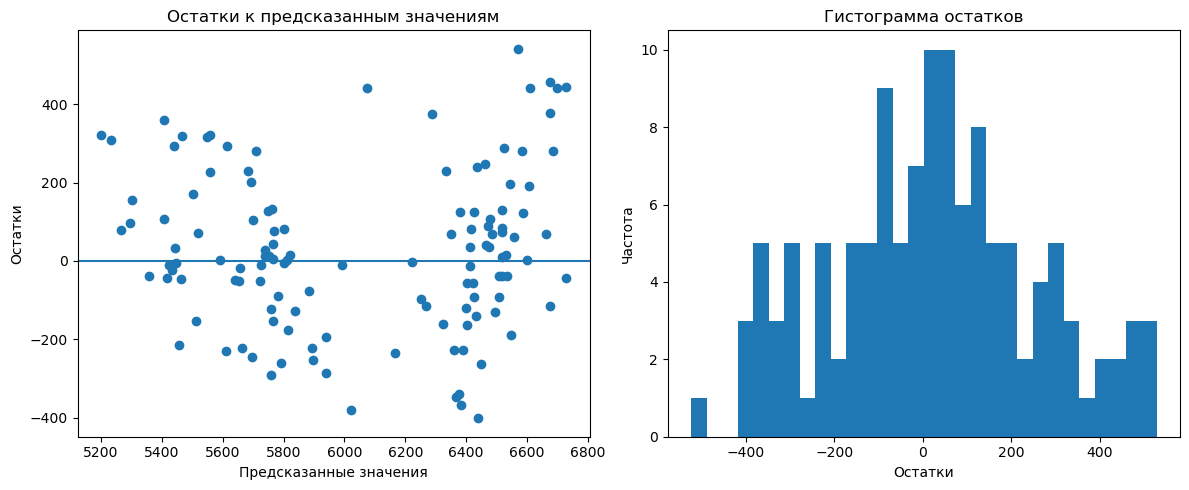

In [73]:
residuals2 = y_test - predictions

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(predictions, residuals2)
axes[0].axhline(0)
axes[0].set_xlabel('Предсказанные значения')
axes[0].set_ylabel('Остатки')
axes[0].set_title('Остатки к предсказанным значениям')

axes[1].hist(residuals, bins=30)
axes[1].set_xlabel('Остатки')
axes[1].set_ylabel('Частота')
axes[1].set_title('Гистограмма остатков')

plt.tight_layout()
plt.show()


**Выводы по второй модели:**

1) Значение R² модели: 0.83 (+0.06)
2) Остатки во второй модели распределены несимметрично с левым сдвигом, что указывает на тенденцию к завышению прогнозов, однако это смещение оказалось менее выраженным по сравнению с первой версией. Кроме того, разброс ошибок на разных уровнях предсказаний стал более равномерным.
3) Всё это говорит о том, что вторая модель работает точнее: устранение нелинейности между признаками и целевой переменной действительно улучшило результаты.
ия).

### Третья модель<a name="19"></a> 

Добавим в модель новый признак: имя папы

In [74]:
ferma_ml3 = ferma_ml2
ferma_ml3.sample(3)

,id,milk_yield_kg,crude_protein_g,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_taste,age,sugar_protein_ratio_c,energy_feed_unit2
86,87,5564.0,1883.0,висбикайдиал,холмистое,айдиал,3.61,3.079,вкусно,менее_2_лет,0,179.56
402,403,6153.0,2169.0,висбикайдиал,равнинное,айдиал,3.59,3.078,невкусно,более_2_лет,1,182.25
266,267,6169.0,1717.0,рефлешнсоверинг,холмистое,айдиал,3.63,3.074,вкусно,более_2_лет,1,237.16


In [75]:
ferma_dad.sample()

,id,sire_name
61,62,барин


Присоединим именна отцов по ключу и глянем вывод:

In [76]:
ferma_ml3 = (
    ferma_ml2
    .merge(
        ferma_dad[['id', 'sire_name']],
        on='id'
    )
)

ferma_ml3.head()

,id,milk_yield_kg,crude_protein_g,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_taste,age,sugar_protein_ratio_c,energy_feed_unit2,sire_name
0,1,5863.0,1743.0,висбикайдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,буйный
1,2,5529.0,2138.0,висбикайдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,соловчик
2,3,5810.0,1854.0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,невкусно,более_2_лет,0,196.00,барин
3,4,5895.0,2012.0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,невкусно,более_2_лет,0,153.76,буйный
4,5,5302.0,1675.0,висбикайдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,барин


In [77]:
y = ferma_ml3['milk_yield_kg']
X = ferma_ml3[['energy_feed_unit2',
                'fat_percent',
                'sugar_protein_ratio_c', 
                'sire_breed', 
                'age', 
                'pasture_type',
              'sire_name']]

numeric_features = ['energy_feed_unit2',
                    'sugar_protein_ratio_c',
                   'fat_percent']

categorical_features = ['pasture_type',
                        'sire_breed',
                        'age',
                       'sire_name']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [79]:
# кодирование категориальных
encoder = OneHotEncoder(drop='first')
encoder.fit(X_train[categorical_features])

X_train_cat_arr = encoder.transform(X_train[categorical_features]).toarray()
X_test_cat_arr = encoder.transform(X_test[categorical_features]).toarray()

encoded_cols = encoder.get_feature_names_out(categorical_features)
X_train_cat = pd.DataFrame(X_train_cat_arr, columns=encoded_cols, index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat_arr, columns=encoded_cols, index=X_test.index)

# масштабирование числовых
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train_num_arr = scaler.transform(X_train[numeric_features])
X_test_num_arr = scaler.transform(X_test[numeric_features])

X_train_num = pd.DataFrame(X_train_num_arr, columns=numeric_features, index=X_train.index)
X_test_num = pd.DataFrame(X_test_num_arr, columns=numeric_features, index=X_test.index)


In [80]:
X_train = pd.concat([X_train_cat, X_train_num], axis=1)
X_test = pd.concat([X_test_cat, X_test_num], axis=1)

display(X_train.head(2), X_test.head(2))

,pasture_type_холмистое,sire_breed_соверин,age_менее_2_лет,sire_name_буйный,sire_name_геркулес,sire_name_соловчик,energy_feed_unit2,sugar_protein_ratio_c,fat_percent
209,0.0,0.0,1.0,1.0,0.0,0.0,-1.984535,-1.273206,-1.185011
312,1.0,1.0,0.0,0.0,0.0,0.0,0.437541,0.785419,0.730612


,pasture_type_холмистое,sire_breed_соверин,age_менее_2_лет,sire_name_буйный,sire_name_геркулес,sire_name_соловчик,energy_feed_unit2,sugar_protein_ratio_c,fat_percent
249,1.0,1.0,0.0,0.0,0.0,0.0,-0.736528,-1.273206,0.112669
558,0.0,1.0,1.0,0.0,0.0,0.0,-1.984535,-1.273206,-2.050132


In [81]:
model_lr3  = LinearRegression()
model_lr3.fit(X_train, y_train)
predictions = model_lr3.predict(X_test)

# рассчитайте значения R2 для линейной регрессии
r2 = r2_score(y_test, predictions)  
mse3 = mean_squared_error(y_test, predictions)
rmse3 = mean_squared_error(y_test, predictions, squared=False)
mae3 = mean_absolute_error(y_test, predictions)
# выведите полученное значение R2
print("R2 LinearRegression =", r2)

R2 LinearRegression = 0.8432859971464906


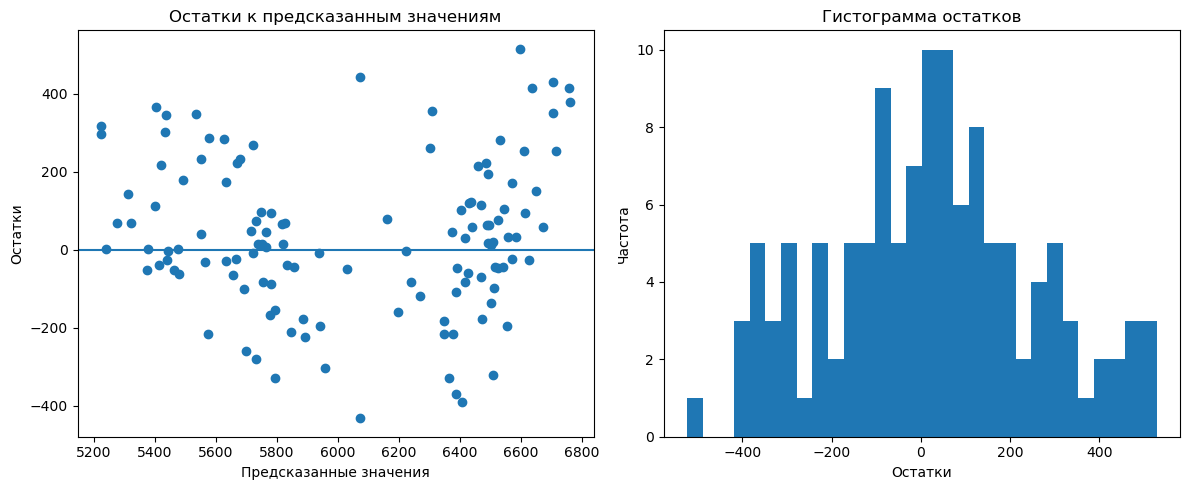

In [82]:
residuals3 = y_test - predictions

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(predictions, residuals3)
axes[0].axhline(0)
axes[0].set_xlabel('Предсказанные значения')
axes[0].set_ylabel('Остатки')
axes[0].set_title('Остатки к предсказанным значениям')

axes[1].hist(residuals, bins=30)
axes[1].set_xlabel('Остатки')
axes[1].set_ylabel('Частота')
axes[1].set_title('Гистограмма остатков')

plt.tight_layout()
plt.show()


**Выводы по третьей модели**

1) Значение R² модели: 0.84 (+0.01 от второй модели)
2) Остатки во второй модели распределены симметрично, а кроме того, разброс ошибок на разных уровнях предсказаний стал ещё более равномерным.
3) Всё это говорит о том, что третья модель работает точнее: устранение нелинейности между признаками и целевой переменной, а также добавления нового признака (имя быка отца) улучшило результаты

**Сравним модели:**

In [83]:
print('R2 первой модели:', 0.7784963153266605)
print('R2 второй модели:', 0.8312887017051531)
print('R2 третькй модели:', 0.8432859971464906)

R2 первой модели: 0.7784963153266605
R2 второй модели: 0.8312887017051531
R2 третькй модели: 0.8432859971464906


In [84]:
print('Первая модель:')
print('MSE', mse)
print('RMSE', rmse)
print('MAE', mae)
print('=====================')
print('Вторая модель:')
print('MSE', mse2)
print('RMSE', rmse2)
print('MAE', mae2)
print('=====================')
print('Третья модель:')
print('MSE', mse3)
print('RMSE', rmse3)
print('MAE', mae3)

Первая модель:
MSE 54683.05117831313
RMSE 233.8440744990412
MAE 186.0169663133885
Вторая модель:
MSE 41650.09070897492
RMSE 204.08353855461965
MAE 158.66739628584304
Третья модель:
MSE 38688.29473891013
RMSE 196.69340288609106
MAE 151.18736853661105


In [85]:
print('Остатки первой модели (среднее):', residuals.mean())
print('Остатки первой модели (среднее):', residuals2.mean())
print('Остатки первой модели (среднее):', residuals3.mean())

Остатки первой модели (среднее): 23.639199880414644
Остатки первой модели (среднее): 27.817552960288886
Остатки первой модели (среднее): 34.17159584678158


По итогам анализ метрик трех моделей можно сказать, что:
1) Наилучшая можель почти по всем показателям - третья. Она имеет наибольшую долю объясненной вариации, а также наименьшие ошибки
2) Наименьшие остатки у первой модели

Для наилучшей модели выведу доверительный интервал:

In [86]:
print('Доверительный интервал третьей модели:', st.norm.interval(confidence=0.95, loc=np.mean(predictions), scale=st.sem(predictions)))

Доверительный интервал третьей модели: (5966.73442164308, 6127.066386663358)


### Прогнозирование коров на покупку<a name="20"></a> 

С помощью лучшей модели спрогнозируем удой коров, которых фермер хочет купить:

In [87]:
cow_buy.sample(3)

,breed,pasture_type,sire_breed,sire_name,current_fat_percent,current_protein_percent,age
16,висбикайдиал,холмистое,соверин,соловчик,3.73,3.079,более_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет
13,висбикайдиал,холмистое,соверин,барин,3.42,3.075,менее_2_лет


In [88]:
ferma_main.sample(3)

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_taste,age,sugar_protein_ratio_c,energy_feed_unit2
585,586,5751.0,13.5,1684.0,0.88,рефлешнсоверинг,равнинное,соверин,3.64,3.071,невкусно,более_2_лет,0,182.25
340,341,5497.0,14.7,1751.0,0.84,висбикайдиал,равнинное,айдиал,3.18,3.074,невкусно,менее_2_лет,0,216.09
373,374,6501.0,15.5,1712.0,0.94,рефлешнсоверинг,равнинное,айдиал,3.72,3.075,вкусно,более_2_лет,1,240.25


In [89]:
mean_values = ferma_main[['energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio']].mean()
new_values = mean_values * 1.05

In [90]:
cow_buy_ml = cow_buy.copy()

cow_buy_ml['energy_feed_unit'] = new_values['energy_feed_unit']
cow_buy_ml['energy_feed_unit2'] = cow_buy_ml['energy_feed_unit'] ** 2
cow_buy_ml['crude_protein_g'] = new_values['crude_protein_g']
cow_buy_ml['sugar_protein_ratio'] = new_values['sugar_protein_ratio']
cow_buy_ml['sugar_protein_ratio_c'] = cow_buy_ml['sugar_protein_ratio'].apply(lambda x: 1 if x > 0.91 else 0)
cow_buy_ml['fat_percent'] = cow_buy_ml['current_fat_percent']
cow_buy_ml = cow_buy_ml.drop(['energy_feed_unit', 'sugar_protein_ratio', 'crude_protein_g', 'breed', 'current_fat_percent'], axis=1)
display(cow_buy_ml.head())

,pasture_type,sire_breed,sire_name,current_protein_percent,age,energy_feed_unit2,sugar_protein_ratio_c,fat_percent
0,холмистое,айдиал,геркулес,3.076,более_2_лет,233.378833,1,3.58
1,равнинное,соверин,буйный,3.081,менее_2_лет,233.378833,1,3.54
2,равнинное,соверин,барин,3.074,более_2_лет,233.378833,1,3.59
3,холмистое,айдиал,буйный,3.061,более_2_лет,233.378833,1,3.40
4,равнинное,айдиал,буйный,3.074,более_2_лет,233.378833,1,3.64


In [91]:
df = cow_buy_ml.copy()

categorical_features = ['pasture_type', 'sire_breed', 'age', 'sire_name']
numeric_features     = [ 'energy_feed_unit2', 'sugar_protein_ratio_c', 'fat_percent']

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
cat_arr = encoder.fit_transform(df[categorical_features]).toarray()
cat_cols = encoder.get_feature_names_out(categorical_features)
df_cat = pd.DataFrame(cat_arr, columns=cat_cols, index=df.index)

scaler = StandardScaler()
num_arr = scaler.fit_transform(df[numeric_features])
df_num = pd.DataFrame(num_arr, columns=numeric_features, index=df.index)

cow_n_ml = pd.concat([df_cat, df_num], axis=1)

cow_n_ml.sample(3)

,pasture_type_холмистое,sire_breed_соверин,age_менее_2_лет,sire_name_буйный,sire_name_геркулес,sire_name_соловчик,energy_feed_unit2,sugar_protein_ratio_c,fat_percent
0,1.0,0.0,0.0,0.0,1.0,0.0,-5.684342e-14,0.0,0.268156
10,1.0,1.0,0.0,0.0,0.0,1.0,-5.684342e-14,0.0,1.380717
15,1.0,0.0,0.0,1.0,0.0,0.0,-5.684342e-14,0.0,-1.066918


In [92]:
cow_buy['milk_yield_kg'] = model_lr3.predict(cow_n_ml)
cow_buy

,breed,pasture_type,sire_breed,sire_name,current_fat_percent,current_protein_percent,age,milk_yield_kg
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6369.588947
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,6094.166999
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,6031.307392
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,6292.118633
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,6292.441715
7,висбикайдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,6292.738555
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,6101.035629
10,висбикайдиал,холмистое,соверин,соловчик,3.73,3.055,более_2_лет,6159.663526
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,3.073,более_2_лет,6365.216501
13,висбикайдиал,холмистое,соверин,барин,3.42,3.075,менее_2_лет,5857.374595


В результате проделанной работы был спрогнозирован годовой удой коров в рамках от 5850.11 до 6366.95 кг.

Определим вкус молока, решив задачу классфиикации.

### Задача классификации<a name="21"></a> 

Заказчие хочет определять вкусное молоко. Для этого построем модель классиикации с таргетом "вкус"

In [93]:
ferma_main

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,sire_breed,fat_percent,protein_percent,milk_taste,age,sugar_protein_ratio_c,energy_feed_unit2
0,1,5863.0,14.2,1743.0,0.890,висбикайдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64
1,2,5529.0,12.8,2138.0,0.890,висбикайдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84
2,3,5810.0,14.0,1854.0,0.885,рефлешнсоверинг,холмистое,соверин,3.59,3.074,невкусно,более_2_лет,0,196.00
3,4,5895.0,12.4,2012.0,0.885,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,невкусно,более_2_лет,0,153.76
4,5,5302.0,12.8,1675.0,0.885,висбикайдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812.0,15.4,1964.0,0.940,рефлешнсоверинг,равнинное,айдиал,3.74,3.075,невкусно,более_2_лет,1,237.16
625,626,5513.0,12.9,1700.0,0.880,рефлешнсоверинг,равнинное,соверин,3.64,3.073,вкусно,менее_2_лет,0,166.41
626,627,5970.0,14.4,1837.0,0.880,рефлешнсоверинг,холмистое,соверин,3.64,3.075,невкусно,более_2_лет,0,207.36
627,628,5746.0,13.8,1994.0,0.890,рефлешнсоверинг,равнинное,соверин,3.64,3.077,вкусно,более_2_лет,0,190.44


In [94]:
y = ferma_main['milk_taste']
X = ferma_main[['energy_feed_unit2', 
                'crude_protein_g', 
                'sugar_protein_ratio_c', 
                'sire_breed', 
                'fat_percent', 
                'protein_percent', 
                'pasture_type', 
                'age', 
                'breed']]

numeric_features = ['energy_feed_unit2', 'crude_protein_g', 'sugar_protein_ratio_c', 'fat_percent', 'protein_percent']

categorical_features = ['sire_breed', 'pasture_type', 'age', 'breed']



In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

y_train = y_train.map({'вкусно': 0, 'невкусно': 1})
y_test = y_test.map({'вкусно': 0, 'невкусно': 1})

In [96]:
# кодирование категориальных
encoder = OneHotEncoder(drop='first')
encoder.fit(X_train[categorical_features])

X_train_cat_arr = encoder.transform(X_train[categorical_features]).toarray()
X_test_cat_arr = encoder.transform(X_test[categorical_features]).toarray()

encoded_cols = encoder.get_feature_names_out(categorical_features)
X_train_cat = pd.DataFrame(X_train_cat_arr, columns=encoded_cols, index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat_arr, columns=encoded_cols, index=X_test.index)

# масштабирование числовых
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])

X_train_num_arr = scaler.transform(X_train[numeric_features])
X_test_num_arr = scaler.transform(X_test[numeric_features])

X_train_num = pd.DataFrame(X_train_num_arr, columns=numeric_features, index=X_train.index)
X_test_num = pd.DataFrame(X_test_num_arr, columns=numeric_features, index=X_test.index)


In [97]:
X_train = pd.concat([X_train_cat, X_train_num], axis=1)
X_test = pd.concat([X_test_cat, X_test_num], axis=1)

display(X_train.head(2), X_test.head(2))

,sire_breed_соверин,pasture_type_холмистое,age_менее_2_лет,breed_рефлешнсоверинг,energy_feed_unit2,crude_protein_g,sugar_protein_ratio_c,fat_percent,protein_percent
211,0.0,0.0,1.0,0.0,-1.984535,-1.158945,-1.273206,-1.185011,-1.053871
315,1.0,1.0,0.0,0.0,0.437541,-0.346166,0.785419,0.730612,0.156339


,sire_breed_соверин,pasture_type_холмистое,age_менее_2_лет,breed_рефлешнсоверинг,energy_feed_unit2,crude_protein_g,sugar_protein_ratio_c,fat_percent,protein_percent
252,1.0,1.0,0.0,1.0,-0.736528,0.108991,-1.273206,0.112669,0.963146
564,1.0,0.0,1.0,0.0,-1.984535,-1.424453,-1.273206,-2.050132,-0.650468


In [98]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [99]:
for feature_number, feature_name in enumerate(X_train.columns):
    exp_weight = math.exp(clf.coef_[0, feature_number])
    print(f"{feature_name:<20}: {exp_weight:+.2f}")

sire_breed_соверин  : +1.09
pasture_type_холмистое: +0.59
age_менее_2_лет     : +1.13
breed_рефлешнсоверинг: +1.08
energy_feed_unit2   : +0.51
crude_protein_g     : +0.84
sugar_protein_ratio_c: +1.62
fat_percent         : +0.95
protein_percent     : +0.83


In [100]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('LogisticRegression model Accuracy = ', round(accuracy, 3))
print('LogisticRegression model Precision = ', round(precision, 3))
print('LogisticRegression model Recall = ', round(recall, 3))

LogisticRegression model Accuracy =  0.608
LogisticRegression model Precision =  0.606
LogisticRegression model Recall =  0.357


Точность модели - 0.6, Recall ~0.3, Precision ~ 0.6

Посмотрим на матрицу ошибок, чтобы понять что делать...

Text(0.5, 23.52222222222222, 'Predicted')

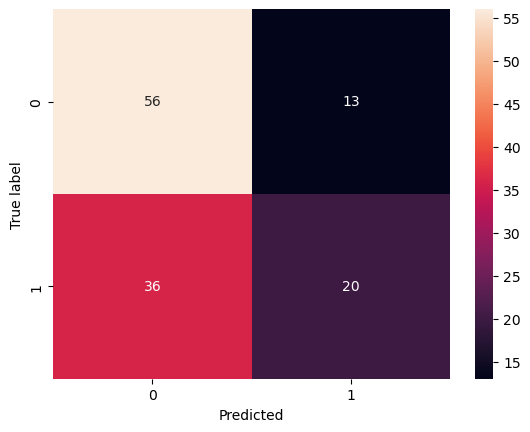

In [101]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted')

Взглянем на матрицу:

1) Правильно вкусное молоко модель определила 20 коров
2) Правильно определила невкусное 56 раз
3) Ошибочно посчитала невкусное вкусным 36 раз
4) Ошибочно вкусное невкусным 13 раз

Заказчику критично, чтобы молоко было вкусное. Следовательно будем уменьшать False Negative ошибку. Нестрашно, если будет отбраковано вкусное молоко и намного хуже, если на стол попадет невкусное. Попробуем изменить порог классификации

In [102]:
thresholds = [round(i,2) for i in np.linspace(0.5,1,num = 4,endpoint=False)]
print(thresholds)

[0.5, 0.62, 0.75, 0.88]


In [103]:
y_proba = clf.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(data.head()) 

    y_valid   y_proba
85        1  0.765752
1         1  0.764523
59        1  0.753735
27        1  0.711736
79        0  0.694527


Добавить пороги поможет функция linspace: она разделяет заданный промежуток на несколько более мелких. Посмотрим на то, как модель будет работать при четырёх разных порогах.

In [104]:
# создаём переменную, которая будет хранить список новых колонок
columns = []

# добавьте столбцы с новыми предсказаниями в таблицу
for i in thresholds:
	columns.append('y_pred_'+str(i))
	data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x>=i else 0)

# выведем 5 случайных строк
data.sample(5)

,y_valid,y_proba,y_pred_0.5,y_pred_0.62,y_pred_0.75,y_pred_0.88
107,0,0.231643,0,0,0,0
90,0,0.311068,0,0,0,0
83,0,0.161687,0,0,0,0
67,0,0.198553,0,0,0,0
119,0,0.468901,0,0,0,0


In [105]:
for i in thresholds:
    print(f'y_pred_{i} Recall = ', recall_score(data['y_valid'], data[f'y_pred_{i}']))

y_pred_0.5 Recall =  0.35714285714285715
y_pred_0.62 Recall =  0.10714285714285714
y_pred_0.75 Recall =  0.05357142857142857
y_pred_0.88 Recall =  0.0


Целевая метрика - recall = 1. Порог классификации должен быть сильно ниже 

In [106]:
thresholds = [round(i,2) for i in np.linspace(0.0,0.5,num = 4,endpoint=False)]
print(thresholds)

[0.0, 0.12, 0.25, 0.38]


In [107]:
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba'])
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

for i in thresholds:
    print(f'y_pred_{i} Recall = ', recall_score(data['y_valid'], data[f'y_pred_{i}']))

y_pred_0.0 Recall =  1.0
y_pred_0.12 Recall =  1.0
y_pred_0.25 Recall =  0.9642857142857143
y_pred_0.38 Recall =  0.6607142857142857


In [108]:
thresholds = [0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba'])
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

for i in thresholds:
    print(f'y_pred_{i} Recall = ', recall_score(data['y_valid'], data[f'y_pred_{i}']))

y_pred_0.21 Recall =  1.0
y_pred_0.22 Recall =  1.0
y_pred_0.23 Recall =  1.0
y_pred_0.24 Recall =  0.9821428571428571
y_pred_0.25 Recall =  0.9642857142857143
y_pred_0.26 Recall =  0.9642857142857143
y_pred_0.27 Recall =  0.9642857142857143
y_pred_0.28 Recall =  0.9285714285714286
y_pred_0.29 Recall =  0.9107142857142857


In [109]:
thresholds = [0.231, 0.232, 0.233, 0.234, 0.235, 0.236, 0.237, 0.238, 0.239]
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba'])
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

for i in thresholds:
    print(f'y_pred_{i} Recall = ', recall_score(data['y_valid'], data[f'y_pred_{i}']))

y_pred_0.231 Recall =  1.0
y_pred_0.232 Recall =  1.0
y_pred_0.233 Recall =  0.9821428571428571
y_pred_0.234 Recall =  0.9821428571428571
y_pred_0.235 Recall =  0.9821428571428571
y_pred_0.236 Recall =  0.9821428571428571
y_pred_0.237 Recall =  0.9821428571428571
y_pred_0.238 Recall =  0.9821428571428571
y_pred_0.239 Recall =  0.9821428571428571


Уровень Recall = 0.232 позволит свести к 0 ошибку при минимальных потерях.

Взглянем же на матрицу ошибок вновь, но уже ограниченную реколом

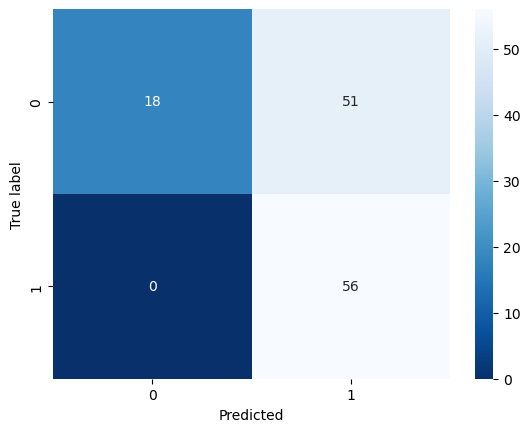

In [110]:
y_pred_new_threshold = (clf.predict_proba(X_test)[:, 1] >= 0.232).astype(int) 
accuracy = accuracy_score(y_test, y_pred_new_threshold)
precision = precision_score(y_test, y_pred_new_threshold)
recall = recall_score(y_test, y_pred_new_threshold)
cm = confusion_matrix(y_test, y_pred_new_threshold)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Теперь на столе у фермера будет только вкусное молоко

#### Прогнозирование вкуса молока по cow_buy<a name="000"></a> 

In [111]:
cow_buycl = cow_buy.copy()
cow_buy.head()

,breed,pasture_type,sire_breed,sire_name,current_fat_percent,current_protein_percent,age,milk_yield_kg
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6369.588947
1,висбикайдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,6094.166999
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,6031.307392
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,6292.118633
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,6292.441715


In [112]:
cow_buycl = cow_buy.copy()

mean_values = ferma_main[['energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio']].mean()
new_values = mean_values * 1.05

cow_buycl['energy_feed_unit'] = new_values['energy_feed_unit']
cow_buycl['crude_protein_g'] = new_values['crude_protein_g']
cow_buycl['sugar_protein_ratio'] = new_values['sugar_protein_ratio']
cow_buycl['protein_percent'] = cow_buycl['current_protein_percent']
 
cow_buycl['energy_feed_unit2'] = cow_buycl['energy_feed_unit'] ** 2
cow_buycl['sugar_protein_ratio_c'] = cow_buycl['sugar_protein_ratio'].apply(lambda x: 1 if x > 0.91 else 0)
cow_buycl['fat_percent'] = cow_buycl['current_fat_percent']
cow_buycl = cow_buycl.drop(['energy_feed_unit', 'sugar_protein_ratio', 'current_protein_percent'], axis=1)
display(cow_buycl.head())

,breed,pasture_type,sire_breed,sire_name,current_fat_percent,age,milk_yield_kg,crude_protein_g,protein_percent,energy_feed_unit2,sugar_protein_ratio_c,fat_percent
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,более_2_лет,6369.588947,2019.77191,3.076,233.378833,1,3.58
1,висбикайдиал,равнинное,соверин,буйный,3.54,менее_2_лет,6094.166999,2019.77191,3.081,233.378833,1,3.54
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,более_2_лет,6031.307392,2019.77191,3.074,233.378833,1,3.59
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,более_2_лет,6292.118633,2019.77191,3.061,233.378833,1,3.40
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,более_2_лет,6292.441715,2019.77191,3.074,233.378833,1,3.64


In [113]:
cow_buycl

,breed,pasture_type,sire_breed,sire_name,current_fat_percent,age,milk_yield_kg,crude_protein_g,protein_percent,energy_feed_unit2,sugar_protein_ratio_c,fat_percent
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,более_2_лет,6369.588947,2019.77191,3.076,233.378833,1,3.58
1,висбикайдиал,равнинное,соверин,буйный,3.54,менее_2_лет,6094.166999,2019.77191,3.081,233.378833,1,3.54
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,более_2_лет,6031.307392,2019.77191,3.074,233.378833,1,3.59
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,более_2_лет,6292.118633,2019.77191,3.061,233.378833,1,3.40
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,более_2_лет,6292.441715,2019.77191,3.074,233.378833,1,3.64
7,висбикайдиал,равнинное,соверин,буйный,3.57,более_2_лет,6292.738555,2019.77191,3.079,233.378833,1,3.57
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,менее_2_лет,6101.035629,2019.77191,3.079,233.378833,1,3.40
10,висбикайдиал,холмистое,соверин,соловчик,3.73,более_2_лет,6159.663526,2019.77191,3.055,233.378833,1,3.73
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.73,более_2_лет,6365.216501,2019.77191,3.073,233.378833,1,3.73
13,висбикайдиал,холмистое,соверин,барин,3.42,менее_2_лет,5857.374595,2019.77191,3.075,233.378833,1,3.42


In [114]:
df = cow_buycl.copy()

categorical_features = ['sire_breed', 'pasture_type', 'age', 'breed']
numeric_features     = ['energy_feed_unit2', 'crude_protein_g', 'sugar_protein_ratio_c', 'fat_percent', 'protein_percent']

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
cat_arr = encoder.fit_transform(df[categorical_features]).toarray()
cat_cols = encoder.get_feature_names_out(categorical_features)
df_cat = pd.DataFrame(cat_arr, columns=cat_cols, index=df.index)

scaler = StandardScaler()
num_arr = scaler.fit_transform(df[numeric_features])
df_num = pd.DataFrame(num_arr, columns=numeric_features, index=df.index)

cow_n_cl = pd.concat([df_cat, df_num], axis=1)

cow_n_cl.sample(3)

,sire_breed_соверин,pasture_type_холмистое,age_менее_2_лет,breed_рефлешнсоверинг,energy_feed_unit2,crude_protein_g,sugar_protein_ratio_c,fat_percent,protein_percent
7,1.0,0.0,0.0,0.0,-5.684342e-14,2.273737e-13,0.0,0.193985,0.893825
2,1.0,0.0,0.0,1.0,-5.684342e-14,2.273737e-13,0.0,0.342327,0.226025
16,1.0,1.0,0.0,0.0,-5.684342e-14,2.273737e-13,0.0,1.380717,0.893825


In [115]:
taste_pred = (clf.predict_proba(cow_n_cl)[:, 1] >= 0.232).astype(int)
taste_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Неожиданный результат. В конце конов он по нижней границе, так что "ослабим требования"

In [116]:
taste_pred = (clf.predict_proba(cow_n_cl)[:, 1] >= 0.3).astype(int)
taste_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

Есть две коровы, у которых молоко должно быть вкусным!

In [117]:
cow_buy['вкус'] = taste_pred

In [118]:
cow_buy[cow_buy['вкус'] == 0]

,breed,pasture_type,sire_breed,sire_name,current_fat_percent,current_protein_percent,age,milk_yield_kg,вкус
0,висбикайдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,6369.588947,0
16,висбикайдиал,холмистое,соверин,соловчик,3.73,3.079,более_2_лет,6159.663526,0


Двух коров должно хватить. Одну даже можно проиграть в винт

## Вывод<a name="22"></a> 

По результатам работы можно сделать выводы о проделанных шагах по порядку:

1) **Предобработка данных**

Данные в виде трех датасетов: cow_buy, cow_dad, ferma_main были загружены и проверены на дубликаты и пропущенные данные в первую очередь, а также были проверены и приведены к нужным типам столбцы с данными.

* ferma_main - нет дубликатов и пропусков, приведены к float 4 столбца
* cow_buy - 4 дубликата были удалены, пропусков нет и все типы данных хороши
* cow_dad - нет проблем в датасете, но были отловлены неявные дубликаты:
    * "Равнинные" --> "Равнинное"
    * "Айдалл" --> "Айдал"
 
Также все столбцы были переименованы на английский язык в едином виде:
* 'id': 'id'
* 'Удой, кг': 'milk_yield_kg'
* 'ЭКЕ (Энергетическая кормовая единица)': 'energy_feed_unit'
* 'Сырой протеин, г': 'crude_protein_g'
* 'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio'
* 'Порода': 'breed'
* 'Тип пастбища': 'pasture_type'
* 'порода папы_быка': 'sire_breed'
* 'Жирность,%': 'fat_percent'
* 'Белок,%': 'protein_percent'
* 'Вкус молока': 'milk_taste'
* 'Возраст': 'age'
* 'Имя_папы': 'sire_name'
* 'Текущая_жирность,%': 'current_fat_percent'
* 'Текущий_уровень_белок,%': 'current_protein_percent'
* 'Возраст': 'age'

Дополнительно все данные типа string были нормализованы: с маленькой буквы, без пробелов

2. **Исследовательский анализ данных**

2.1.1.) **milk_yield**
* По признаку milk_yield_kg нашелся один выброс. От него можно просто безболезненно избавиться. Видно, что распределение признака отдалённо напоминает нормальное, но все же недо конца. Вероятно, это связано со спецификой признака (например, коров, которые в год дают <5200 л. молока нерентабельно ни содержать на ферме, ни продавать)
1. **Нормальность:** распределение в целом близко к нормальному, с лёгким скошением вправо (более длинный «хвост» к большим значениям).
2. **Выбросы:** явных выбросов нет – «усы» укладываются примерно от \~5200 до \~7250 кг без отдельных точек за пределами.
3. **Основной диапазон:** большинство значений сосредоточено между 5700 и 6700 кг; медиана примерно на уровне 6150–6250 кг.
4. **Примечание:** нижние значения (\~5200–5500 кг) могут соответствовать первотёлкам или коровам в ранней лактации, тогда как верхний диапазон (\~7000+ кг) характерен для высокопродуктивных особей.


2.1.2.) **energy_feed_unit**
1. **Нормальность:** распределение примерно симметричное, близко к нормальному, с лёгким уклоном влево.
2. **Выбросы:** явных выбросов нет – значения от \~11 до \~17 укладываются в «усы» без крайних точек.
3. **Основной диапазон:** большинство значений лежит между 13 и 16 единицами; медиана около 14,7–15,0.
4. **Примечание:** нижние значения (\~11–12) могут относиться к кормлению молодняка или особым режимам, тогда как 14–16 — стандартный уровень для основной группы коров.

2.1.3.) **crude_protein_g**
1. **Нормальность:** распределение близко к симметричному, но есть лёгкий сдвиг вправо и намёк на две группы (около 1750 и 2200 г).
2. **Выбросы:** явных выбросов нет – «усы» тянутся примерно от 1650 до 2350 г без отдельных точек.
3. **Основной диапазон:** большинство значений лежит между \~1800 и \~2050 г; медиана около 1900 г.
4. **Примечание:** низкие значения (\~1650–1750 г) могут соответствовать базовым рационам, высокие (\~2200+ г) – усиленному протеиновому питанию для высокопродуктивных коров.

2.1.4.) **sugar_protein_ratio**
1. **Нормальность:** форма не идеально нормальная, есть «скопления» значений (примерно вокруг 0.89 и 0.93), небольшой сдвиг вправо.
2. **Выбросы:** явных выбросов нет — размах от \~0.84 до \~0.96 укладывается в усы без отдельных точек.
3. **Основной диапазон:** большинство значений сосредоточено между \~0.89 и \~0.94; медиана около 0.92-0.93.
4. **Примечание:** дискретные «пики» могут отражать разные режимы кормления или стадии лактации: низкие соотношения (\~0.84–0.87) — для одной группы коров, высокие (\~0.93–0.95) — для другой.

2.1.5.) **fat_percent**
1. **Нормальность:** распределение сильно не нормальное – выраженный сдвиг влево (большой «пик» на высоких значениях и длинный «хвост» к низким).
2. **Выбросы:** множество точек-выбросов слева (жирности \~3.0–3.4 %), которые лежат ниже нижнего «уса» (нижний квартиль примерно около 3.55 %) Однако их слишком много (approx. 13%) и избавиться от них "безболезненно" не выйдет. Посмотрим что мы с ними можем сделать.
3. **Основной диапазон:** центральные 50 % значений сосредоточены между ≈3.55 % и ≈3.72 %; медиана около 3.65 %.
4. **Примечание:** высокая концентрация в районе 3.65–3.75 % говорит о стандартном уровне жирности большинства коров, тогда как низкие значения (\~3.0–3.4 %) могут соответствовать либо первым отёлам, либо сезонным/рационным изменениям.

2.1.6.) **protein_percent**
1. **Нормальность:** распределение близко к нормальному, симметричное вокруг ≈3.076 %;
2. **Выбросы:** есть единичные точки слева (\~3.070) и справа (\~3.082–3.085), лежащие за «усами», от них можно и избавиться;
3. **Основной диапазон:** центральные 50 % значений примерно от 3.074 % до 3.078 %; медиана ≈3.076 %;
4. **Примечание:** крайние низкие или высокие проценты белка могут отражать особенности питания, стадию лактации или погрешности измерения.

2.2.1) **current_fat_percent**
1. **Нормальность:** распределение выглядит относительно симметричным, хоть и дискретным (данных немного и они сгруппированы вокруг нескольких значений). Явного уклона нет.
2. **Выбросы:** на боксплоте нет отдельных точек за пределами «усов» — все значения (примерно от 3.32 до 3.75 %) укладываются в допустимый диапазон без ярко выраженных выбросов.
3. **Основной диапазон:** центральные 50 % значений лежат примерно между 3.52 % и 3.68 % (медиана около 3.60 %).
4. **Примечание:** низкие показания (\~3.32–3.40 %) вероятно соответствуют коровам в начале лактации или при изменении рациона, а верхние (\~3.70–3.75 %) — зрелым животным со стабильно высоким содержанием жира.

2.2.2) **current_protein_percent**
1. **Нормальность:** данных немного и они дискретны, но в целом распределение скучено вокруг \~3.075 % с небольшим «хвостом» вниз — близко к симметричному, но не идеально нормальное.
2. **Выбросы:** одна точка около 3.045 % лежит за нижним «усом» на боксплоте и считается выбросом.
3. **Основной диапазон:** остальные значения сосредоточены между ≈3.055 % и ≈3.080 %; медиана примерно на уровне 3.075 %.
4. **Примечание:** низкая точка (\~3.045 %) может относиться к корове с пониженным содержанием белка (возможно, первотёлка или особые условия кормления), тогда как большинство животных демонстрируют 3.07–3.08 % билируина.

===============================================

**Размерность количественных признаков**

1) Видно два типа «висбид айдиал» (368) и «рефлешн соверинг» (255) — первая порода заметно преобладает.
2) Категории «холмистое» (348) и «равнинное» (275), при этом холмистое чуть более распространено.
3) «айдиал» (314) и «соверин» (309) почти равномерно представлены.
4) две категории «вкусно» (366) и «невкусно» (257), вкусовое предпочитают чаще, но разрыв не слишком большой.
5) «более_2_лет» (514) доминирует над «менее_2_лет» (109) — большинство коров старше двух лет, молодняка существенно меньше.

================================================

**Был проведен анализ корреляции:**
1) Очень сильно на вкус молока влияет содержание в нем сахара
2) С надоем очень сильно коррелируют процент жирности, порода отца, отношение сахара к протеину в корме и энергетическая ценность корма, но об этом поговорим позже
3) Процент жирности сильно коррелирует со многими параметрами коровы и её питания

**Были проверены корреляции признаков при помощи диаграмм рассеяния:**

1) **Зависимость надоя от питательности корма:** видна довольно четкая прямая корреляция между тем насколько питательный корм у коровы и тем сколько надоя в год она даёт. Энергетические единицы (energy_feed_unit) – самый сильный драйвер роста milk_yield_kg. Обе породы чётко показывают: чем кормить «больше энергии», тем выше общий объём молока. У «рефлешн соверинг» эта зависимость, кажется, чуть более выражена на верхних уровнях кормления, но общее направление одинаковое. И слава Богу.
2) **Зависимость надоя от содержания сырого протеина в корме:** прослеживается слабая прямая корреляция между этими двумя параметрами. Сырое содержание протеина в рационе оказывает определённое влияние, но гораздо слабее, чем «чистая» энергия. Разброс точек говорит о том, что много других факторов («еда», «порода», «пасбище») вносят шум. При увеличении протеина выше ~2000 г молоко растёт, но именно «протеин + сопутствующая энергия» работают в связке, поэтому одному протеину доверять не стоит.
3) **Зависимость надоя от сахаро-протеинового соотношения в корме:** на графике мы можем заметить несколько "палочек" на константных знаечниях соотношения. Как видно, что после определенного порога в районе 0.91 значение надоя резко растет. При этом высокое соотношение сахара к протеину особо положительно сказывается на надое рефлешн соверингов.
4) **Зависимость надоя от содержания жира:** Диапазон значений молока растёт вместе с ростом жирности, но здесь опять видно, что точки разного цвета сильно пересекаются. У «висбикайдиал» (синие) чуть больше разброс на низкой жирности, тогда как у оранжевых («рефлешнсоверинг») часто наблюдаются более высокие урожаи близ 3.7 % жирности. Но чёткой границы (скажем, «жирность > 3.65 % = всегда больше молока вне зависимости от породы») нет — всё перемешано.
5) **Зависимость надоя от процента протеина:** Доля белка в молоке protein_percent в данном наборе практически никак не связана с объёмом производства (milk_yield_kg). Она настолько константна (от 3.070 до 3.080 %), что не даёт никакой дополнительной информации о том, «сколько литров» (килограммов) молока будет произведено.

**Кратко о типах связей:**
1) Практически линейная (жёсткое восхождение/убывание) – energy_feed_unit → milk_yield_kg.
2) Слабая линейная – crude_protein_g → milk_yield_kg (есть тренд, но сильный шум).
3) Почти отсутствует или очень слабо выражена – sugar_protein_ratio, fat_percent и особенно protein_percent.

**Касаемо нелинейности и новых переменных:**

Явных негладких или сильно «изогнутых» кривых (U-, S-, лог- или экспонент-связей) не наблюдается. Всё вписывается в приближённо линейную модель («прямая плюс шум»), разве что с лёгким «затуханием» в максимуме energy_feed_unit, но оно настолько слабо, что не требует обязательного полинома. Вводить новые признаки не требуется, або линейная регрессия (или любая линейная модель с регуляризацией) вполне сможет отработать эти связи: energy Feed + протеин + остальные признаки «как есть».

**Мультиколлинеарность:**

Скорее всего, да, присутствует умеренная: особенно между `energy_feed_unit` и `crude_protein_g` (потому что более «энергетичные» корма обычно богаты протеином).

3. **Построение моделей для решения задачи регрессии**

3.1.) Первая модель

1. Значение R² модели: 0.77

2. Из анализа остатков следует, что среднее значение ошибок близко к нулю (систематических смещений нет), но при возрастании предсказанных значений разброс остатков увеличивается (гетероскедастичность), а гистограмма показывает лёгкие «хвосты» и несколько выбросов (остатки не полностью нормальны).

3. Я заметил интересную тенденцию, что остатки образуют нечто похожее на параболу ветвями вниз (либо просто два линейных паттерна: нисходящий и восходящий последовательно). Это требует дополнительного исследованияия).

3.2.) Вторая модель

1) Значение R² модели: 0.83 (+0.06)
2) Остатки во второй модели распределены несимметрично с левым сдвигом, что указывает на тенденцию к завышению прогнозов, однако это смещение оказалось менее выраженным по сравнению с первой версией. Кроме того, разброс ошибок на разных уровнях предсказаний стал более равномерным.
3) Всё это говорит о том, что вторая модель работает точнее: устранение нелинейности между признаками и целевой переменной действительно улучшило результаты.
ия).

3.3.) Третья модель

1) Значение R² модели: 0.84 (+0.01 от второй модели)
2) Остатки во второй модели распределены симметрично, а кроме того, разброс ошибок на разных уровнях предсказаний стал ещё более равномерным.
3) Всё это говорит о том, что третья модель работает точнее: устранение нелинейности между признаками и целевой переменной, а также добавления нового признака (имя быка отца) улучшило результаты

Наилучшая можель почти по всем показателям - третья. Она имеет наибольшую долю объясненной вариации, а также наименьшие ошибки. Наименьшие остатки у первой модели. В результате проделанной работы был спрогнозирован годовой удой коров в рамках от 5850.11 до 6366.95 кг. Таким образом мы определили вкус молока, решив задачу классфиикации.

4. **Построение моделей для решения задачи классификации**

Мы построили матрицу ошибок и выяснили:
1) Правильно вкусное молоко модель определила 20 коров
2) Правильно определила невкусное 56 раз
3) Ошибочно посчитала невкусное вкусным 36 раз
4) Ошибочно вкусное невкусным 13 раз

Заказчику критично, чтобы молоко было вкусное. Следовательно будем уменьшать False Negative ошибку. Нестрашно, если будет отбраковано вкусное молоко и намного хуже, если на стол попадет невкусное. Попробуем изменить порог классификации

Уровень Recall = 0.232 позволил свести к 0 ошибку при минимальных потерях.

Мы отобрали две подходящие заказчику коровы: id = 0; id = 16